## Hybrid_Sim

### Load packages

In [37]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
import matplotlib.patches as mpatches
import itertools
import os
import pandas as pd

# Set random seeds for NumPy and Python's `random` module.
# Ensures that the simulation results are reproducible each time the code is run with the same seed.
# If reproducibility is not required, these lines can be commented out.
np.random.seed(32)
random.seed(32)

### Global Simulation Parameters

In [38]:
# Global Simulation Parameters
# These parameters define the structure and scale of the simulated generations and the chromosomes and loci details.
# They are set globally and are used across various functions and classes in the simulation.

# chromosome_length: The total number of genetic loci (marker positions) present on a single haploid chromatid.
chromosome_length = 100

# NUM_CHROMOSOMES_P0_F1: The number of diploid chromosome pairs individuals in the P0 and F1 generations.
# For simplicity, P0 and F1 individuals are modelled with a single chromosome pair.
NUM_CHROMOSOMES_P0_F1 = 1

# NUM_CHROMOSOMES_F2_ONWARDS: The number of diploid chromosome pairs for individuals from the F2 generation onwards.
NUM_CHROMOSOMES_F2_ONWARDS = 10

# Population Sizes for Different Generations
# These global constants define the target number of individuals to be simulated for each generation.

NUM_F1_INDIVIDUALS = 20    # Number of individuals in the F1 generation.
NUM_F2_INDIVIDUALS = 20    # Number of individuals in the F2 generation.
NUM_F3_INDIVIDUALS = 20    # Number of individuals in the F3 generation.
NUM_F4_INDIVIDUALS = 20    # Number of individuals in the F4 generation.

# Number of individuals for Backcross generations.
# BC1_A: Backcross of F1 to P0_A (MM parent)
NUM_BC1_A_INDIVIDUALS = 20
# BC1_B: Backcross of F1 to P0_B (YY parent)
NUM_BC1_B_INDIVIDUALS = 20
# BC2_A: Backcross of F2 to P0_A (MM parent)
NUM_BC2_A_INDIVIDUALS = 20
# BC2_B: Backcross of F2 to P0_B (YY parent)
NUM_BC2_B_INDIVIDUALS = 20

# Define allele types and their corresponding colours for visualisation.
MAGENTA = 'M' # Represents the allele from parental line A (MM).
YELLOW = 'Y'  # Represents the allele from parental line B (YY).

# Global colour map: associates allele symbols with specific colours for plotting.
col_map = {MAGENTA: 'magenta', YELLOW: 'yellow'}

# Global list to store all genetic data records (locus-level genotypes).
# Each dictionary in this list will represent the genotype at a single locus for a given individual.
genetic_data_records = []

# Global list to store chromatid-level recombination data (block lengths, junctions).
# This list stores raw data for each chromatid, which will then be aggregated for DataFrames.
chromatid_recombination_records = []

# Global list to store all Individual objects created during the simulation.
# This allows easy access to individual-level metrics like Hybrid Index and Heterozygosity.
all_individuals_created = []

# Global counter for assigning unique identification numbers to each individual created in the simulation.
# Starts at 1 to ensure individual IDs are 1-indexed
individual_id_counter = 1

### Class Definitions

In [39]:
# Class Definitions (Chromosome, DiploidChromosomePair, Individual)
# This cell defines the biological components that form the basis of the genetic simulation:
# a single DNA strand (Chromosome), a pair of homologous chromosomes (DiploidChromosomePair),
# and an entire organism (Individual). The 'Individual' class is extended with methods
# to calculate key genetic metrics such as Hybrid Index and Heterozygosity.

class Chromosome:
    """
    Represents a single haploid chromatid (a single strand of DNA).
    It is a linear sequence of alleles at defined loci.
    In a diploid organism, two chromatids form a chromosome pair.
    """
    def __init__(self, alleles):
        # 'alleles' is a list of characters (e.g., 'M', 'Y'), where each character
        # corresponds to the allele present at a specific locus on this chromatid.
        self.alleles = alleles

    def __repr__(self):
        # Provides a string representation of a Chromosome object.
        # It displays a snippet of the alleles to give an idea of its content without printing the entire sequence.
        snippet = ''.join(self.alleles[:10]) if self.alleles else ''
        return f"Chr({snippet}...)"

class DiploidChromosomePair:
    """
    Represents a pair of chromosomes within a diploid organism.
    One chromatid in the pair is typically inherited from one parent (e.g., paternal origin),
    and the other from the other parent (e.g., maternal origin).
    """
    def __init__(self, chromatid1, chromatid2):
        # 'chromatid1' and 'chromatid2' are instances of the Chromosome class.
        # These represent the two chromatids that constitute this diploid pair.
        self.chromatid1 = chromatid1
        self.chromatid2 = chromatid2

    def __repr__(self):
        # Provides a string representation for a DiploidChromosomePair, showing both constituent chromatids.
        return f"Pair(\n  {self.chromatid1}\n  {self.chromatid2}\n)"

class Individual:
    """
    Represents a single organism in the simulation. An individual is defined by its
    unique ID, total number of chromosome pairs, and the length of those chromosomes.
    This class includes methods to calculate the Hybrid Index and Heterozygosity
    across the entire genome of the individual.
    """
    def __init__(self, num_chromosomes, num_loci_per_chromosome):
        global individual_id_counter # Access the global counter to assign unique IDs.
        self.id = individual_id_counter # Assign a unique integer ID to this individual.
        individual_id_counter += 1 # Increment the counter for the next individual to be created.

        # 'num_chromosomes': The total count of diploid chromosome pairs in an individual.
        self.num_chromosomes = num_chromosomes
        # 'num_loci_per_chromosome': The number of loci found on each chromatid.
        self.num_loci_per_chromosome = num_loci_per_chromosome
        # 'diploid_chromosome_pairs': A list that will hold all the DiploidChromosomePair objects
        #                             that make up this individual's entire hypothetical "genome".
        self.diploid_chromosome_pairs = []

    def __repr__(self):
        # A string representation for an Individual, indicating its ID and the number of chromosome pairs.
        return f"Individual (ID: {self.id}) with {len(self.diploid_chromosome_pairs)} diploid chromosome pairs."

    def get_all_numeric_genotypes(self):
        """
        Gathers all genotype data for the individual across its entire "genome" (all chromosome pairs, all loci).
        It converts the allele pairs (e.g., 'M', 'Y') into a numeric representation for calculation:
        - YY (homozygous Yellow) = 0 (zero 'M' alleles)
        - MY (heterozygous)      = 1 (one 'M' allele)
        - MM (homozygous Magenta)= 2 (two 'M' alleles)

        Returns:
            list: A single, flattened list of integers (0, 1, or 2) representing the genotype at each locus
                  across *all* diploid chromosome pairs of this individual. This is the raw data used for metrics.
        """
        all_numeric_genotypes = []
        # Iterate through each diploid chromosome pair that belongs to this individual.
        for diploid_pair in self.diploid_chromosome_pairs:
            # Get the allele sequences from both chromatids in the current pair.
            alleles_chromatid1 = diploid_pair.chromatid1.alleles
            alleles_chromatid2 = diploid_pair.chromatid2.alleles

            # Iterate through each locus (position) along the length of these chromatids.
            for i in range(self.num_loci_per_chromosome):
                allele_a = alleles_chromatid1[i]
                allele_b = alleles_chromatid2[i]
                # Sort the alleles to ensure consistent ordering (e.g., 'MY' instead of 'YM') for ease of simulation purposes.
                # before assigning a numeric genotype.
                pair = sorted([allele_a, allele_b])

                # Assign numeric genotype based on the sorted allele pair composition.
                if pair == [MAGENTA, MAGENTA]: # Homozygous for Magenta alleles.
                    all_numeric_genotypes.append(2)
                elif pair == [YELLOW, YELLOW]: # Homozygous for Yellow alleles.
                    all_numeric_genotypes.append(0)
                else: # Must be heterozygous (one Magenta, one Yellow allele).
                    all_numeric_genotypes.append(1)
        return all_numeric_genotypes

    def calculate_hybrid_index(self):
        """
        Calculates the aggregate Hybrid Index (HI) for this individual across its entire "genome".
        The HI quantifies the proportion of alleles originating from one parental lineage (specifically Magenta 'M')
        out of all alleles across all loci. It ranges from 0 (all Yellow alleles) to 1 (all Magenta alleles).

        Returns:
            float: The calculated Hybrid Index for the individual, aggregated across all chromosomes.
        """
        # First, retrieve all numeric genotypes for all diploid chromosome pairs in an individual.
        all_numeric_genotypes = self.get_all_numeric_genotypes()

        # Calculate the total number of alleles across all chromosomes.
        # Since each locus has two alleles (one from each chromatid in a diploid pair),
        # the total possible alleles is twice the number of loci.
        total_possible_alleles = len(all_numeric_genotypes) * 2

        # Debugging step: stop division by zero in the rare case of an individual having no loci (e.g., an empty Individual object).
        if total_possible_alleles == 0:
            return 0.0

        # The sum of numeric genotypes (0 for YY, 1 for MY, 2 for MM) directly corresponds
        # to the total count of 'M' (Magenta) alleles present across all chromosomes an individual holds.
        sum_of_m_alleles = sum(all_numeric_genotypes)

        # The Hybrid Index is the proportion of Magenta alleles out of the total possible alleles.
        hybrid_index = sum_of_m_alleles / total_possible_alleles
        return hybrid_index

    def calculate_heterozygosity(self):
        """
        Calculates the aggregate Heterozygosity (He) for this individual across all its chromosomes.
        Heterozygosity represents the proportion of heterozygous loci (MY genotypes)
        out of all loci in the individual's genome. It ranges from 0 (all loci homozygous)
        to 1 (all loci heterozygous).

        Returns:
            float: The calculated Heterozygosity for the individual, aggregated across all chromosomes.
        """
        # Retrieve all numeric genotypes for the individual's full genome.
        all_numeric_genotypes = self.get_all_numeric_genotypes()

        # Count how many of these loci are heterozygous (where the numeric genotype is 1).
        num_heterozygous_loci = all_numeric_genotypes.count(1)

        # The total number of loci across the entire genome is the total count
        # of numeric genotypes that were collected.
        total_num_loci_across_all_chroms = len(all_numeric_genotypes)

        # Prevent division by zero if the individual has no loci.
        if total_num_loci_across_all_chroms == 0:
            return 0.0

        # Heterozygosity is the proportion of heterozygous loci out of all loci.
        heterozygosity = num_heterozygous_loci / total_num_loci_across_all_chroms
        return heterozygosity

    # Method to get recombination block data for all chromatids in the individual
    def get_chromatid_block_data(self):
        """
        Analyses each chromatid within the individual's diploid chromosome pairs
        to determine block lengths and count recombination junctions.

        A 'block' is defined as a contiguous stretch of loci with the same allele (M or Y).
        A 'junction' is defined as a change in allele type (e.g., M -> Y or Y -> M)
        along a single chromatid.

        Returns:
            list: A list of dictionaries, where each dictionary contains data
                  for one chromatid:
                  {
                      'individual_id': int,
                      'diploid_chr_id': int (1-indexed ID of the diploid pair),
                      'chromatid_in_pair': str ('A' or 'B', indicating which chromatid in the pair),
                      'total_junctions': int,
                      'block_lengths': list of int (lengths of consecutive blocks of the same allele),
                      'block_alleles': list of str (allele type of each block, e.g., 'M', 'Y')
                  }
        """
        all_chromatid_data = []
        chromatid_labels = ['A', 'B'] # Define labels for chromatids in a pair

        for chr_idx, diploid_pair in enumerate(self.diploid_chromosome_pairs):
            # Create a list of the two chromatids in the current pair
            # This allows us to loop through them and avoid code duplication
            chromatids_in_pair = [diploid_pair.chromatid1, diploid_pair.chromatid2]

            # Process each chromatid within the pair
            for i, chromatid in enumerate(chromatids_in_pair):
                chromatid_alleles = chromatid.alleles
                # Call the helper method to get analysis results for the current chromatid
                junctions, lengths, alleles = self._analyse_single_chromatid(chromatid_alleles)

                # Append the structured data for the current chromatid
                all_chromatid_data.append({
                    'individual_id': self.id,
                    'diploid_chr_id': chr_idx + 1,          # 1-indexed chromosome ID
                    'chromatid_in_pair': chromatid_labels[i], # Use 'A' or 'B' based on index
                    'total_junctions': junctions,
                    'block_lengths': lengths,
                    'block_alleles': alleles
                })
        return all_chromatid_data

    # Helper method to analyse a single chromatid
    def _analyse_single_chromatid(self, alleles):
        """
        Helper method to analyse a single chromatid's allele sequence for blocks and junctions.
        Uses itertools.groupby for efficient block identification.

        Args:
            alleles (list): A list of allele characters (e.g., 'M', 'Y') for a single chromatid.

        Returns:
            tuple: (num_junctions, list_of_block_lengths, list_of_block_alleles)
        """
        if not alleles:
            return 0, [], []

        block_lengths = []
        block_alleles = []

        # itertools.groupby groups consecutive identical elements.
        # For example, ['M', 'M', 'Y', 'Y', 'Y', 'M'] becomes:
        # ('M', iterator for ['M', 'M'])
        # ('Y', iterator for ['Y', 'Y', 'Y'])
        # ('M', iterator for ['M'])
        for allele_type, group in itertools.groupby(alleles):
            length = len(list(group)) # Convert group iterator to list to get its length
            block_lengths.append(length)
            block_alleles.append(allele_type)

        # The number of junctions is always one less than the number of blocks.
        # If there's only one block (no change), junctions = 0.
        num_junctions = len(block_lengths) - 1 if block_lengths else 0

        return num_junctions, block_lengths, block_alleles

# Helper function to record an individual's detailed genomic data into the global list.
def _record_individual_genome_for_detailed_dataframe(individual, generation_stage_label):
    """
    Records the detailed genotype information for an individual at each locus
    into the global 'genetic_data_records' list. This list will later be converted
    into a pandas DataFrame for comprehensive data analysis.

    Args:
        individual (Individual): The individual whose genome data is to be recorded.
        generation_stage_label (str): A string label indicating the generation stage of the individual
                                      (e.g., "P0_A", "F1", "F2", "BC1_A").
    """
    # Iterate through each diploid chromosome pair that the individual possesses.
    # 'chr_idx' serves as a 0-indexed counter for the chromosome pair.
    for chr_idx, diploid_pair in enumerate(individual.diploid_chromosome_pairs):
        # Iterate through each locus position along the length of the chromosomes.
        for locus_idx in range(individual.num_loci_per_chromosome):
            # Extract the alleles from both chromatids at the current locus.
            allele_a = diploid_pair.chromatid1.alleles[locus_idx]
            allele_b = diploid_pair.chromatid2.alleles[locus_idx]

            # This line will preserve the order, e.g., if allele_a='Y' and allele_b='M', it will be 'Y|M'.
            genotype_str = f"{allele_a}|{allele_b}"

            # Append a dictionary representing this locus's data to the global records list.
            # 'diploid_chr_id' is 1-indexed for better readability (e.g., Chr 1, Chr 2).
            genetic_data_records.append({
                'generation': generation_stage_label,
                'individual_id': individual.id, # This is the unique ID for the whole individual
                'diploid_chr_id': chr_idx + 1, # This is the ID for the specific diploid chromosome pair within the individual
                'locus_position': locus_idx,
                'genotype': genotype_str # The combined genotype at this specific locus (e.g., 'M|Y' or 'Y|M').
            })

# Helper function to record chromatid-level recombination data
def _record_chromatid_recombination_data(individual, generation_stage_label):
    """
    Records block lengths and junction counts for each chromatid of an individual.
    Appends data to the global 'chromatid_recombination_records' list.

    Args:
        individual (Individual): The individual whose chromatid data is to be recorded.
        generation_stage_label (str): A string label indicating the generation stage of the individual.
    """
    chromatid_data = individual.get_chromatid_block_data()
    for record in chromatid_data:
        record['generation'] = generation_stage_label # Add generation label to each chromatid record
        chromatid_recombination_records.append(record)

### Recombination Setup

In [40]:
# Recombination Setup

# This cell defines the probabilities that govern how genetic recombination (crossovers) occurs
# during gamete formation. These probabilities dictate how parental alleles are shuffled
# onto new chromatids.

# use_uniform_recomb: A boolean flag to switch between two recombination models.
# - True: Uses a constant, uniform recombination probability across the entire chromosome.
# - False: Uses a custom, locus-specific recombination probability profile.
use_uniform_recomb = True # Set to True for this simulation to use uniform recombination.

if use_uniform_recomb:
    # Uniform Recombination Model:
    # Each interval between adjacent loci (marker sites) has an equal chance of a crossover occurring.
    # A probability of 0.5 effectively means independent assortment between adjacent loci if no interference.
    # There are (chromosome_length - 1) intervals on a chromosome.
    recomb_probs_for_crosses = [0.5] * (chromosome_length - 1)
else:
    # Custom Recombination Model:
    # This setup allows for varying recombination rates along the chromosome, simulating "hotspots" or "coldspots".
    recomb_probs_for_crosses = [0.0] * (chromosome_length - 1) # Initialize all intervals with 0.0 recombination probability.
    for i in range(chromosome_length - 1):
        # Define a specific region (from locus 45 to 54, inclusive) as a "hotspot" with
        # a higher recombination probability (0.1).
        if 45 <= i < 55:
            recomb_probs_for_crosses[i] = 0.1

# recomb_event_probs_for_crosses: Defines the probabilities of a specific number of crossover events occurring
# on a single chromatid during meiosis.
# This list is a probability distribution: P(0 crossovers), P(1 crossover), P(2 crossovers).
# [0, 1, 0] means that exactly one crossover event will always occur if recombination is enabled and possible.
recomb_event_probs_for_crosses = [0, 1, 0]

### Diagnostic Cell (Parameters & Recomb)

In [41]:
print("Sanity Check 1: Global Parameters & Recombination Setup")
print(f"Chromosome Length: {chromosome_length}")
print(f"NUM_CHROMOSOMES_P0_F1: {NUM_CHROMOSOMES_P0_F1}")
print(f"NUM_CHROMOSOMES_F2_ONWARDS: {NUM_CHROMOSOMES_F2_ONWARDS}")
print(f"Alleles: MAGENTA='{MAGENTA}', YELLOW='{YELLOW}'")

print(f"\nUse Uniform Recombination: {use_uniform_recomb}")
if use_uniform_recomb:
    print(f"Uniform Recombination Probability per interval: {recomb_probs_for_crosses[0]}")
    print(f"Number of intervals: {len(recomb_probs_for_crosses)}")
else:
    print(f"Custom Recombination Probabilities (first 5): {recomb_probs_for_crosses[:5]}...")
print(f"Recombination Event Probabilities (P(0), P(1), P(2) crossovers): {recomb_event_probs_for_crosses}")
print(f"This means: Always {recomb_event_probs_for_crosses.index(1)} crossover event(s) when recombination occurs.")

Sanity Check 1: Global Parameters & Recombination Setup
Chromosome Length: 100
NUM_CHROMOSOMES_P0_F1: 1
NUM_CHROMOSOMES_F2_ONWARDS: 10
Alleles: MAGENTA='M', YELLOW='Y'

Use Uniform Recombination: True
Uniform Recombination Probability per interval: 0.5
Number of intervals: 99
Recombination Event Probabilities (P(0), P(1), P(2) crossovers): [0, 1, 0]
This means: Always 1 crossover event(s) when recombination occurs.


In [ ]:
# --- Load initial populations from CSV ---
#print(f"Loading initial populations from {INITIAL_POPULATIONS_CSV}...")
#loaded_generations_dict, inferred_chromosome_length, inferred_num_diploid_chromosomes_p0 = \
    #load_initial_populations_from_csv(INITIAL_POPULATIONS_CSV)

# Assign your P0 populations from the loaded dictionary (assuming 'P0_A' and 'P0_B' are values in your 'Generation' column)
#p0_a_population = loaded_generations_dict.get('P0_A', [])
#p0_b_population = loaded_generations_dict.get('P0_B', [])

# Update global CHROMOSOME_LENGTH
#global CHROMOSOME_LENGTH
#CHROMOSOME_LENGTH = inferred_chromosome_length

### Gamete Formation and Offspring Generation Functions

In [42]:
# Gamete Formation and Offspring Generation Helper Functions
# This cell contains the sophisticated functions that simulate how parents produce gametes
# (haploid sets of chromosomes) and how these gametes combine to form offspring.
# This is where recombination, the shuffling of parental alleles, takes place.

def form_gamete_from_diploid_pair(diploid_chromosome_pair, chromosome_length, recomb_event_probabilities, recomb_probabilities):
    """
    Simulates the process of meiosis for a single diploid chromosome pair to produce one haploid chromatid.
    This function accounts for crossover events (recombination) between the two homologous chromatids
    within the pair, generating a recombinant chromatid for the gamete.

    Args:
        diploid_chromosome_pair (DiploidChromosomePair): The parental chromosome pair from which the gamete is formed.
        chromosome_length (int): The total number of loci on the chromosome.
        recomb_event_probabilities (list): A list of probabilities for 0, 1, or 2 crossover events.
                                      (e.g., [P(0_crossovers), P(1_crossover), P(2_crossovers)]).
        recomb_probabilities (list): A list of probabilities for a crossover occurring at each specific
                               interval between adjacent loci. (Length = chromosome_length - 1).

    Returns:
        Chromosome: A newly generated haploid Chromosome object, which is a recombinant chromatid.
    """
    # Extract the allele sequences from the two homologous chromatids in the diploid pair.
    parent_alleles_strand1 = diploid_chromosome_pair.chromatid1.alleles
    parent_alleles_strand2 = diploid_chromosome_pair.chromatid2.alleles

    # Handle very short chromosomes (length <= 1) as recombination is not meaningful.
    # In such cases, simply choose one of the parental strands to pass on directly.
    if chromosome_length <= 1:
        chosen_strand = random.choice([parent_alleles_strand1, parent_alleles_strand2])
        return Chromosome(list(chosen_strand))

    # Determine the number of crossover events that will occur on this chromatid,
    # based on the provided probabilities (recomb_event_probabilities).
    num_recombs = random.choices([0, 1, 2], weights=recomb_event_probabilities, k=1)[0]

    # Ensure that the number of recombination events doesn't exceed the physically
    # possible number of intervals between loci (chromosome_length - 1).
    max_crossovers_possible = chromosome_length - 1
    num_recombs = min(num_recombs, max_crossovers_possible)

    # If no recombination events are determined (num_recombs is 0), or if the
    # recombination probabilities across all intervals sum to zero (meaning no
    # crossover can happen), then simply return a non-recombinant copy of one
    # of the parental strands.
    if num_recombs == 0 or sum(recomb_probabilities) == 0:
        chosen_strand = random.choice([parent_alleles_strand1, parent_alleles_strand2])
        return Chromosome(list(chosen_strand))

    # If recombination is to occur:
    # Select the specific locations (indices of intervals) where crossovers will happen.
    # `random.choices` is used with `weights` to allow for non-uniform recombination rates (hotspots/coldspots).
    crossover_point_indices = random.choices(range(max_crossovers_possible), weights=recomb_probabilities, k=num_recombs)
    # Convert to a sorted set to get unique crossover points and ensure they are processed in order along the chromosome.
    crossover_points = sorted(list(set(crossover_point_indices)))

    # Initialise the gamete chromatid's alleles.
    gamete_alleles = [None] * chromosome_length
    # Randomly choose which of the two parental strands (chromatid1 or chromatid2) to start copying from.
    current_source_alleles = list(parent_alleles_strand1) if random.random() < 0.5 else list(parent_alleles_strand2)
    # The other strand is the alternative source, which will be swapped to after a crossover.
    other_source_alleles = list(parent_alleles_strand2) if current_source_alleles == list(parent_alleles_strand1) else list(parent_alleles_strand1)

    current_segment_start_idx = 0 # Marks the beginning of the current segment being copied.

    # Iterate through each determined crossover point.
    for crossover_point_idx in crossover_points:
        # A crossover at `crossover_point_idx` means the genetic material switches *after* that locus.
        # So, the segment goes from `current_segment_start_idx` up to `crossover_point_idx + 1` (exclusive).
        segment_end = crossover_point_idx + 1

        # Copy the alleles for the current segment from the `current_source_alleles` strand.
        for i in range(current_segment_start_idx, segment_end):
            gamete_alleles[i] = current_source_alleles[i]

        # After copying a segment, a crossover occurs, so swap the source strands for the next segment.
        current_source_alleles, other_source_alleles = other_source_alleles, current_source_alleles
        # Update the starting index for the next segment to be copied.
        current_segment_start_idx = segment_end

    # After all crossovers are processed, copy the remaining alleles from the final source strand
    # to complete the construction of the gamete chromatid.
    for i in range(current_segment_start_idx, chromosome_length):
        gamete_alleles[i] = current_source_alleles[i]

    return Chromosome(gamete_alleles)

def produce_haploid_set_of_chromosomes_for_gamete(parent_individual, target_num_chromosomes_in_gamete_set, chromosome_length_for_gamete, recomb_event_probabilities, recomb_probabilities):
    """
    Generates a complete set of haploid chromatids that would make up a gamete (e.g., sperm or egg).
    For each diploid chromosome pair in the parent, one recombinant chromatid is produced.

    A crucial feature here is handling cases where the parent has *fewer* chromosome pairs than the
    target number for the offspring's gamete set (e.g., P0 parents with 1 chromosome contributing to F2 with 10).
    In such scenarios, gametes from the parent's *first* chromosome pair are replicated to meet the target count,
    simulating independent assortment for new chromosomes if the parent only has one "model" chromosome.

    Args:
        parent_individual (Individual): The parent organism from which the gamete set is being generated.
        target_num_chromosomes_in_gamete_set (int): The desired number of chromatids in the
                                                    returned gamete set.
        chromosome_length_for_gamete (int): The number of loci on each chromosome.
        recomb_event_probabilities (list): Probabilities for 0, 1, or 2 crossover events.
        recomb_probabilities (list): Locus-specific recombination probabilities.

    Returns:
        list: A list of Chromosome objects, collectively representing a full haploid gamete set.
    """
    gamete_chromatids = [] # Initialise an empty list to store the generated chromatids for this gamete.

    # If the parent has no chromosome pairs, it cannot produce gametes.
    if not parent_individual.diploid_chromosome_pairs:
        return []

    # Determine the total number of chromatids that need to be generated for this gamete set.
    # This will typically be NUM_CHROMOSOMES_F2_ONWARDS (10) when creating F2 individuals onwards.
    # The 'target_num_chromosomes_in_gamete_set' parameter is always provided as an integer,
    # so the 'if ... else' part is simplified to just use the parameter directly.
    num_to_generate = target_num_chromosomes_in_gamete_set

    # Get the actual list of chromosome pairs present in the parent.
    parent_actual_pairs = parent_individual.diploid_chromosome_pairs
    num_parent_actual_pairs = len(parent_actual_pairs)

    # Loop to generate each chromatid for the gamete set.
    for i in range(num_to_generate):
        # If the parent has enough distinct chromosome pairs for the target gamete set,
        # use the corresponding pair.
        if i < num_parent_actual_pairs:
            pair_to_use = parent_actual_pairs[i]
        else:
            # If the target number of chromosomes for the gamete set is greater than the
            # number of physical chromosome pairs the parent actually possesses (e.g., P0 has 1, F2 needs 10),
            # then replicate gametes from the parent's *first* chromosome pair.
            # This simulates new, independently assorted chromosomes originating from the same source.
            if num_parent_actual_pairs > 0:
                pair_to_use = parent_actual_pairs[0]
            else:
                # This fallback should ideally not be reached due to the initial check for empty parent pairs.
                # If reached, it means the parent has no chromosomes, so no gametes can be formed.
                continue

        # Generate a single recombinant chromatid from the chosen diploid pair.
        gamete_chromatids.append(
            form_gamete_from_diploid_pair(
                pair_to_use,
                chromosome_length_for_gamete, # CHANGED: Used the correct parameter for chromosome length
                recomb_event_probabilities,
                recomb_probabilities
            )
        )
    return gamete_chromatids

def generate_offspring_individual(parent_a_individual, parent_b_individual, target_num_chromosomes, chromosome_length, recomb_event_probabilities, recomb_probabilities):
    """
    Creates a single offspring individual by combining one gamete set from each of two parent individuals.
    This simulates sexual reproduction where each parent contributes a haploid set of chromosomes.

    Args:
        parent_a_individual (Individual): The first parent individual contributing a gamete.
        parent_b_individual (Individual): The second parent individual contributing a gamete.
        target_num_chromosomes (int): The desired number of diploid chromosome pairs for the offspring.
        chromosome_length (int): The length (number of loci) of each chromosome.
        recomb_event_probabilities (list): Probabilities for crossover events.
        recomb_probabilities (list): Locus-specific recombination probabilities.

    Returns:
        Individual: A newly generated Individual object representing the offspring.
    """
        # Create the new offspring individual
    offspring_individual = Individual(target_num_chromosomes, chromosome_length) # Add this line here!
    
    # Produce a complete haploid set of chromosomes (a gamete) from the first parent.
    # This gamete will contain 'target_num_chromosomes' (e.g., 10) chromatids.
    gamete_a_chromosomes = produce_haploid_set_of_chromosomes_for_gamete(
        parent_a_individual, target_num_chromosomes, chromosome_length,
        recomb_event_probabilities, recomb_probabilities
    )
    gamete_b_chromosomes = produce_haploid_set_of_chromosomes_for_gamete(
        parent_b_individual, target_num_chromosomes, chromosome_length,
        recomb_event_probabilities, recomb_probabilities
    )

    # Combine corresponding chromatids from each gamete to form the offspring's diploid chromosome pairs.
    for i in range(target_num_chromosomes):
        # Ensure that both gamete sets contain the expected number of chromatids
        # before attempting to form a pair. This prevents index errors.
        if i < len(gamete_a_chromosomes) and i < len(gamete_b_chromosomes):
            # Randomly determine which gamete contributes as chromatid1 vs chromatid2
            chromatid1_from_gamete_a = random.random() < 0.5

            if chromatid1_from_gamete_a:
                offspring_individual.diploid_chromosome_pairs.append(
                    DiploidChromosomePair(gamete_a_chromosomes[i], gamete_b_chromosomes[i])
                )
            else:
                offspring_individual.diploid_chromosome_pairs.append(
                    DiploidChromosomePair(gamete_b_chromosomes[i], gamete_a_chromosomes[i])
                )
        else:
            print(f"Warning: Gamete set incomplete for offspring individual (ID: {offspring_individual.id}). Expected {target_num_chromosomes} chromosomes for pair {i}, but got A:{len(gamete_a_chromosomes)}, B:{len(gamete_b_chromosomes)}. Stopping pair creation for this individual.")
            break # Stop creating pairs for this individual if gametes are insufficient.

    return offspring_individual


def run_genetic_cross(parent_population_a, parent_population_b, num_offspring_to_create, generation_label, num_chromosomes_for_offspring, recomb_event_probabilities, recomb_probabilities):
    """
    Performs a genetic cross between two specified parent populations to generate a new offspring population.
    This is the core generalised function for generating any subsequent generation (F2, F3, BC, etc.).

    Args:
        parent_population_a (list): A list of Individual objects representing the first parent population.
                                    One parent will be randomly selected from this list for each offspring.
        parent_population_b (list): A list of Individual objects representing the second parent population.
                                    One parent will be randomly selected from this list for each offspring.
        num_offspring_to_create (int): The target number of offspring to generate for this new generation.
        generation_label (str): A string label for this new generation (e.g., "F2", "F3", "BC1_A").
                                This label will be recorded in the detailed genetic data.
        num_chromosomes_for_offspring (int): The number of diploid chromosome pairs that each offspring
                                              in this generation will possess.
        recomb_event_probabilities (list): Probabilities for 0, 1, or 2 crossover events.
        recomb_probabilities (list): Locus-specific recombination probabilities.

    Returns:
        list: A new list of Individual objects, representing the newly generated offspring population.
    """
    new_generation_population = [] # Initialise an empty list to store the offspring.

    print(f"\n--- Generating {generation_label} Population ({num_offspring_to_create} individuals) ---")

    # Loop until the desired number of offspring for the new generation has been created.
    while len(new_generation_population) < num_offspring_to_create:
        # Randomly select one parent from each of the provided parent populations.
        # This allows for various cross types (e.g., F1 x F1, F1 x P0, etc.).
        parent_a = random.choice(parent_population_a)
        parent_b = random.choice(parent_population_b)

        # Generate a single offspring individual from the selected parents.
        # The 'offspring' variable holds the newly created Individual object.
        offspring = generate_offspring_individual(
            parent_a, parent_b, num_chromosomes_for_offspring, chromosome_length,
            recomb_event_probabilities, recomb_probabilities
        )

        # Add the newly created offspring individual to the population list.
        new_generation_population.append(offspring)
        # Add the offspring to the global list of all individuals
        all_individuals_created.append(offspring)

        # Record the detailed genome data for this offspring into the global records list.
        _record_individual_genome_for_detailed_dataframe(offspring, generation_label)

        # NEW: Record the chromatid-level recombination data for this offspring.
        # This will populate the 'chromatid_recombination_records' global list.
        _record_chromatid_recombination_data(offspring, generation_label)

    print(f"Generated {len(new_generation_population)} {generation_label} individuals.")
    return new_generation_population

### P0 Generation Creation and Initial Calculations

In [43]:
# P0 Generation Creation and Calculations
# This cell handles the initial setup of the founding parental (P0) generation.
# These individuals are the pure lines, homozygous for one of the two allele types.

def create_pure_parent(allele_type, num_chromosomes, num_loci_per_chromosome, generation_label):
    """
    Generates a homozygous parent individual (a pure line).
    Each of its chromosome pairs will contain two identical chromatids,
    both entirely composed of the specified 'allele_type'.

    Args:
        allele_type (str): The allele ('M' or 'Y') that will define this parent's genotype.
        num_chromosomes (int): The total number of diploid chromosome pairs for this parent.
        num_loci_per_chromosome (int): The number of loci on each chromatid.
        generation_label (str): The label for this parent's generation (e.g., "P0_A", "P0_B").

    Returns:
        Individual: A new Individual object representing the homozygous parent.
    """
    individual = Individual(num_chromosomes, num_loci_per_chromosome)
    for _ in range(num_chromosomes):
        # Create two identical chromatids, filled with the specified allele type.
        chromatid1 = Chromosome([allele_type] * num_loci_per_chromosome)
        chromatid2 = Chromosome([allele_type] * num_loci_per_chromosome)
        # Add the homozygous diploid pair to the individual's genome.
        individual.diploid_chromosome_pairs.append(DiploidChromosomePair(chromatid1, chromatid2))

    # Add the individual to the global list of all individuals
    all_individuals_created.append(individual)

    # Record the individual's genome immediately after creation.
    # This records locus-level genotype strings (e.g., 'M|M').
    _record_individual_genome_for_detailed_dataframe(individual, generation_label)

    # NEW: Record the chromatid-level recombination data (blocks and junctions).
    # For P0 individuals, you expect 0 junctions and 1 block (the full chromosome length) per chromatid.
    _record_chromatid_recombination_data(individual, generation_label)

    return individual

print("--- Creating P0 Generation ---")

# Create the first parental line: P0_A (Magenta homozygous parent).
# This parent (MM) is the source of Magenta alleles.
p0_a_individual = create_pure_parent(MAGENTA, NUM_CHROMOSOMES_P0_F1, chromosome_length, "P0_A")
# Store in a list, as `run_genetic_cross` expects a population list.
p0_a_population = [p0_a_individual]

# Create the second parental line: P0_B (Yellow homozygous parent).
# This parent (YY) is the source of Yellow alleles.
p0_b_individual = create_pure_parent(YELLOW, NUM_CHROMOSOMES_P0_F1, chromosome_length, "P0_B")
# Store in a list.
p0_b_population = [p0_b_individual]

# Calculate the Hybrid Index (HI) and Heterozygosity (He) for the P0 parents.
# These calculations use the methods in the 'Individual' class, which correctly
# aggregate values over the single chromosome pair each P0 parent possesses.
p0_a_hi = p0_a_individual.calculate_hybrid_index()
p0_a_het = p0_a_individual.calculate_heterozygosity()

p0_b_hi = p0_b_individual.calculate_hybrid_index()
p0_b_het = p0_b_individual.calculate_heterozygosity()

# Print the calculated values for verification.
# For pure homozygous parents, HI should be 1.0 (for Magenta parent, P0_A) or 0.0 (for Yellow parent, P0_B),
# and Heterozygosity should be 0.0 (as there are no heterozygous loci).
print(f"P0_A (Magenta) Parent HI: {p0_a_hi:.2f}")
print(f"P0_A (Magenta) Parent Heterozygosity: {p0_a_het:.2f}")
print(f"P0_B (Yellow) Parent HI: {p0_b_hi:.2f}")
print(f"P0_B (Yellow) Parent Heterozygosity: {p0_b_het:.2f}")

--- Creating P0 Generation ---
P0_A (Magenta) Parent HI: 1.00
P0_A (Magenta) Parent Heterozygosity: 0.00
P0_B (Yellow) Parent HI: 0.00
P0_B (Yellow) Parent Heterozygosity: 0.00


### Diagnostic Cell (Ancestry Lines)

In [44]:
print("\nSanity Check P0-1: Global Individuals List & ID Counter")

print(f"Total individuals created globally so far: {len(all_individuals_created)}")
# Expected: 2 (p0_a_individual and p0_b_individual)

print(f"P0_A individual ID: {p0_a_individual.id}")
print(f"P0_B individual ID: {p0_b_individual.id}")
# Expected: IDs should be consecutive, e.g., 1 and 2

print(f"Current individual_id_counter value: {individual_id_counter}")
# Expected: 3 (ready for the next individual to be ID 3)


Sanity Check P0-1: Global Individuals List & ID Counter
Total individuals created globally so far: 2
P0_A individual ID: 1
P0_B individual ID: 2
Current individual_id_counter value: 3


In [45]:
print("\nSanity Check P0-2: P0 Genetic Data Records")

# Filter for P0_A and P0_B records
p0a_records = [rec for rec in genetic_data_records if rec['individual_id'] == p0_a_individual.id]
p0b_records = [rec for rec in genetic_data_records if rec['individual_id'] == p0_b_individual.id]

print(f"Number of P0_A genetic records: {len(p0a_records)}")
# Expected: chromosome_length * NUM_CHROMOSOMES_P0_F1 = 100 * 1 = 100
print(f"Number of P0_B genetic records: {len(p0b_records)}")
# Expected: 100

print("\nExample P0_A genetic record (first 5):")
for i in range(min(5, len(p0a_records))):
    record = p0a_records[i]
    print(f"  Gen: {record['generation']}, ID: {record['individual_id']}, Chr: {record['diploid_chr_id']}, Locus: {record['locus_position']}, Genotype: {record['genotype']}")
    # Expected: generation="P0_A", individual_id=p0_a.id, diploid_chr_id=1, locus_position=0-99, genotype="M|M"

print("\nExample P0_B genetic record (first 5):")
for i in range(min(5, len(p0b_records))):
    record = p0b_records[i]
    print(f"  Gen: {record['generation']}, ID: {record['individual_id']}, Chr: {record['diploid_chr_id']}, Locus: {record['locus_position']}, Genotype: {record['genotype']}")
    # Expected: generation="P0_B", individual_id=p0_b.id, diploid_chr_id=1, locus_position=0-99, genotype="Y|Y"

# Verify all genotypes for P0_A are M|M
all_p0a_genotypes_correct = all(rec['genotype'] == f"{MAGENTA}|{MAGENTA}" for rec in p0a_records)
print(f"\nAll P0_A genotypes 'M|M': {all_p0a_genotypes_correct}")
# Expected: True

# Verify all genotypes for P0_B are Y|Y
all_p0b_genotypes_correct = all(rec['genotype'] == f"{YELLOW}|{YELLOW}" for rec in p0b_records)
print(f"All P0_B genotypes 'Y|Y': {all_p0b_genotypes_correct}")
# Expected: True


Sanity Check P0-2: P0 Genetic Data Records
Number of P0_A genetic records: 100
Number of P0_B genetic records: 100

Example P0_A genetic record (first 5):
  Gen: P0_A, ID: 1, Chr: 1, Locus: 0, Genotype: M|M
  Gen: P0_A, ID: 1, Chr: 1, Locus: 1, Genotype: M|M
  Gen: P0_A, ID: 1, Chr: 1, Locus: 2, Genotype: M|M
  Gen: P0_A, ID: 1, Chr: 1, Locus: 3, Genotype: M|M
  Gen: P0_A, ID: 1, Chr: 1, Locus: 4, Genotype: M|M

Example P0_B genetic record (first 5):
  Gen: P0_B, ID: 2, Chr: 1, Locus: 0, Genotype: Y|Y
  Gen: P0_B, ID: 2, Chr: 1, Locus: 1, Genotype: Y|Y
  Gen: P0_B, ID: 2, Chr: 1, Locus: 2, Genotype: Y|Y
  Gen: P0_B, ID: 2, Chr: 1, Locus: 3, Genotype: Y|Y
  Gen: P0_B, ID: 2, Chr: 1, Locus: 4, Genotype: Y|Y

All P0_A genotypes 'M|M': True
All P0_B genotypes 'Y|Y': True


In [46]:
print("\nSanity Check P0-3: P0 Chromatid Recombination Records")

# Filter for P0_A and P0_B records
p0a_recomb_records = [rec for rec in chromatid_recombination_records if rec['individual_id'] == p0_a_individual.id]
p0b_recomb_records = [rec for rec in chromatid_recombination_records if rec['individual_id'] == p0_b_individual.id]

print(f"Number of P0_A chromatid recombination records: {len(p0a_recomb_records)}")
# Expected: 2 (one for each chromatid in the single diploid pair)
print(f"Number of P0_B chromatid recombination records: {len(p0b_recomb_records)}")
# Expected: 2

print("\nExample P0_A chromatid recombination record (both):")
for record in p0a_recomb_records:
    print(f"  Gen: {record['generation']}, ID: {record['individual_id']}, Chr: {record['diploid_chr_id']}, Chromatid: {record['chromatid_in_pair']}")
    print(f"    Junctions: {record['total_junctions']}, Block Lengths: {record['block_lengths']}, Block Alleles: {record['block_alleles']}")
    # Expected: Junctions=0, Block Lengths=[chromosome_length], Block Alleles=['M']

print("\nExample P0_B chromatid recombination record (both):")
for record in p0b_recomb_records:
    print(f"  Gen: {record['generation']}, ID: {record['individual_id']}, Chr: {record['diploid_chr_id']}, Chromatid: {record['chromatid_in_pair']}")
    print(f"    Junctions: {record['total_junctions']}, Block Lengths: {record['block_lengths']}, Block Alleles: {record['block_alleles']}")
    # Expected: Junctions=0, Block Lengths=[chromosome_length], Block Alleles=['Y']

# Programmatic checks
all_p0_recomb_correct = True
for record in p0a_recomb_records + p0b_recomb_records:
    if record['total_junctions'] != 0:
        print(f"ERROR: P0 individual {record['individual_id']} has unexpected junctions.")
        all_p0_recomb_correct = False
    if record['block_lengths'] != [chromosome_length]:
        print(f"ERROR: P0 individual {record['individual_id']} has unexpected block lengths.")
        all_p0_recomb_correct = False
    if record['block_alleles'] not in [[MAGENTA], [YELLOW]]:
        print(f"ERROR: P0 individual {record['individual_id']} has unexpected block alleles.")
        all_p0_recomb_correct = False

print(f"\nAll P0 recombination records are as expected (0 junctions, 1 full-length block): {all_p0_recomb_correct}")
# Expected: True


Sanity Check P0-3: P0 Chromatid Recombination Records
Number of P0_A chromatid recombination records: 2
Number of P0_B chromatid recombination records: 2

Example P0_A chromatid recombination record (both):
  Gen: P0_A, ID: 1, Chr: 1, Chromatid: A
    Junctions: 0, Block Lengths: [100], Block Alleles: ['M']
  Gen: P0_A, ID: 1, Chr: 1, Chromatid: B
    Junctions: 0, Block Lengths: [100], Block Alleles: ['M']

Example P0_B chromatid recombination record (both):
  Gen: P0_B, ID: 2, Chr: 1, Chromatid: A
    Junctions: 0, Block Lengths: [100], Block Alleles: ['Y']
  Gen: P0_B, ID: 2, Chr: 1, Chromatid: B
    Junctions: 0, Block Lengths: [100], Block Alleles: ['Y']

All P0 recombination records are as expected (0 junctions, 1 full-length block): True


### F1 Generation Creation and Calculations

In [47]:
# --- F1 Generation Creation and Calculations ---
# The F1 generation is created by crossing the two pure parental lines (P0_A x P0_B).
# F1 individuals will be heterozygous across all loci (M|Y).
# They will have NUM_CHROMOSOMES_P0_F1 (1) diploid chromosome pair.

f1_population = run_genetic_cross(
    p0_a_population, p0_b_population, NUM_F1_INDIVIDUALS, "F1",
    NUM_CHROMOSOMES_P0_F1, recomb_event_probs_for_crosses, recomb_probs_for_crosses
)

# Calculate and print average HI and He for the F1 population.
# For a standard F1 cross, HI should be 0.5 and Heterozygosity should be 1.0.
f1_hi_values = [ind.calculate_hybrid_index() for ind in f1_population]
f1_het_values = [ind.calculate_heterozygosity() for ind in f1_population]
print(f"Average F1 Hybrid Index: {np.mean(f1_hi_values):.2f}")
print(f"Average F1 Heterozygosity: {np.mean(f1_het_values):.2f}")



--- Generating F1 Population (20 individuals) ---
Generated 20 F1 individuals.
Average F1 Hybrid Index: 0.50
Average F1 Heterozygosity: 1.00


### Diagnostic Cell F1 Gen

In [48]:
print("\n Sanity Check 2: Individual-Level Inspection (First F1)")

if f1_population:
    first_f1_ind = f1_population[0]
    print(f"Inspecting First F1 individual (ID: {first_f1_ind.id}):")
    print(f"  Number of diploid pairs: {len(first_f1_ind.diploid_chromosome_pairs)}")
    # Expected: NUM_CHROMOSOMES_P0_F1 (which is 1)

    print(f"  Individual Hybrid Index: {first_f1_ind.calculate_hybrid_index():.2f}")
    print(f"  Individual Heterozygosity: {first_f1_ind.calculate_heterozygosity():.2f}")
    # Expected: HI=0.50, He=1.00 for this specific individual

    if first_f1_ind.diploid_chromosome_pairs:
        f1_pair = first_f1_ind.diploid_chromosome_pairs[0]
        print(f"  First Diploid Pair Chromosome Length: {len(f1_pair.chromatid1.alleles)}")
        # Expected: chromosome_length (100)

        # Check the alleles of the two chromatids
        chromatid1_alleles_str = ''.join(f1_pair.chromatid1.alleles[:5]) + "..." + ''.join(f1_pair.chromatid1.alleles[-5:])
        chromatid2_alleles_str = ''.join(f1_pair.chromatid2.alleles[:5]) + "..." + ''.join(f1_pair.chromatid2.alleles[-5:])
        print(f"  Chromatid 1 alleles (start/end): {chromatid1_alleles_str}")
        print(f"  Chromatid 2 alleles (start/end): {chromatid2_alleles_str}")

        # Programmatic check for chromatid purity
        is_chromatid1_pure_M = all(a == MAGENTA for a in f1_pair.chromatid1.alleles)
        is_chromatid1_pure_Y = all(a == YELLOW for a in f1_pair.chromatid1.alleles)
        is_chromatid2_pure_M = all(a == MAGENTA for a in f1_pair.chromatid2.alleles)
        is_chromatid2_pure_Y = all(a == YELLOW for a in f1_pair.chromatid2.alleles)

        if (is_chromatid1_pure_M and is_chromatid2_pure_Y) or (is_chromatid1_pure_Y and is_chromatid2_pure_M):
            print("  SUCCESS: Chromatids in F1 pair are a pure M and a pure Y, as expected.")
        else:
            print("  WARNING: Chromatids in F1 pair are NOT a pure M and a pure Y. Check P0 gamete formation.")
            # This would indicate an issue if recombination happened in P0 gametes (which it shouldn't for pure P0).
    else:
        print("  WARNING: F1 individual has no diploid chromosome pairs.")
else:
    print("No F1 individuals to inspect.")


 Sanity Check 2: Individual-Level Inspection (First F1)
Inspecting First F1 individual (ID: 3):
  Number of diploid pairs: 1
  Individual Hybrid Index: 0.50
  Individual Heterozygosity: 1.00
  First Diploid Pair Chromosome Length: 100
  Chromatid 1 alleles (start/end): MMMMM...MMMMM
  Chromatid 2 alleles (start/end): YYYYY...YYYYY
  SUCCESS: Chromatids in F1 pair are a pure M and a pure Y, as expected.


In [49]:
print("\nSanity Check F1-3: F1 Genetic Data Records")

# Filter for F1 records using their IDs
f1_ids = [ind.id for ind in f1_population]
f1_genetic_records = [rec for rec in genetic_data_records if rec['individual_id'] in f1_ids]

print(f"Number of F1 genetic records: {len(f1_genetic_records)}")
# Expected: NUM_F1_INDIVIDUALS * chromosome_length * NUM_CHROMOSOMES_P0_F1 (e.g., 20 * 100 * 1 = 2000)

if f1_genetic_records:
    print("Example F1 genetic record (first 5):")
    for i in range(min(5, len(f1_genetic_records))):
        record = f1_genetic_records[i]
        print(f"  Gen: {record['generation']}, ID: {record['individual_id']}, Chr: {record['diploid_chr_id']}, Locus: {record['locus_position']}, Genotype: {record['genotype']}")
        # Expected: generation="F1", individual_id=an F1 ID, diploid_chr_id=1, locus_position=0-99, genotype="M|Y" or "Y|M"

    # --- NEW: Count M|Y and Y|M genotypes ---
    my_count = 0
    ym_count = 0
    for record in f1_genetic_records:
        if record['genotype'] == f"{MAGENTA}|{YELLOW}":
            my_count += 1
        elif record['genotype'] == f"{YELLOW}|{MAGENTA}":
            ym_count += 1

    print(f"\nTotal 'M|Y' genotypes found: {my_count}")
    print(f"Total 'Y|M' genotypes found: {ym_count}")
    print(f"Total heterozygous genotypes (M|Y + Y|M): {my_count + ym_count}")
    # Expected: The sum (my_count + ym_count) should equal len(f1_genetic_records).
    # Expected: my_count and ym_count should be approximately equal, given random assignment.

    # Programmatic check: Ensure all F1 genotypes are heterozygous
    all_f1_genotypes_heterozygous = (my_count + ym_count == len(f1_genetic_records))
    print(f"\nAll F1 genotypes are heterozygous (M|Y or Y|M): {all_f1_genotypes_heterozygous}")
    # Expected: True
else:
    print("No F1 genetic records found to perform genotype counting.")


Sanity Check F1-3: F1 Genetic Data Records
Number of F1 genetic records: 2000
Example F1 genetic record (first 5):
  Gen: F1, ID: 3, Chr: 1, Locus: 0, Genotype: M|Y
  Gen: F1, ID: 3, Chr: 1, Locus: 1, Genotype: M|Y
  Gen: F1, ID: 3, Chr: 1, Locus: 2, Genotype: M|Y
  Gen: F1, ID: 3, Chr: 1, Locus: 3, Genotype: M|Y
  Gen: F1, ID: 3, Chr: 1, Locus: 4, Genotype: M|Y

Total 'M|Y' genotypes found: 1100
Total 'Y|M' genotypes found: 900
Total heterozygous genotypes (M|Y + Y|M): 2000

All F1 genotypes are heterozygous (M|Y or Y|M): True


In [50]:
print("\n Sanity Check F1-4: F1 Chromatid Recombination Records")

# Filter for F1 records using their IDs
f1_ids = [ind.id for ind in f1_population]
f1_recomb_records = [rec for rec in chromatid_recombination_records if rec['individual_id'] in f1_ids]

print(f"Number of F1 chromatid recombination records: {len(f1_recomb_records)}")
# Expected: NUM_F1_INDIVIDUALS * NUM_CHROMOSOMES_P0_F1 * 2 (for 2 chromatids per pair) = 20 * 1 * 2 = 40

if f1_recomb_records:
    print("Example F1 chromatid recombination record (first 2):")
    for i in range(min(2, len(f1_recomb_records))): # Just check the first two for a representative
        record = f1_recomb_records[i]
        print(f"  Gen: {record['generation']}, ID: {record['individual_id']}, Chr: {record['diploid_chr_id']}, Chromatid: {record['chromatid_in_pair']}")
        print(f"    Junctions: {record['total_junctions']}, Block Lengths: {record['block_lengths']}, Block Alleles: {record['block_alleles']}")
        # Expected: Junctions=0, Block Lengths=[chromosome_length], Block Alleles=['M'] or ['Y']

    # Programmatic check for F1 chromatids being non-recombinant
    all_f1_chromatids_non_recombinant = True
    for record in f1_recomb_records:
        if record['total_junctions'] != 0:
            print(f"ERROR: F1 individual {record['individual_id']} has unexpected junctions in its chromatid.")
            all_f1_chromatids_non_recombinant = False
        if record['block_lengths'] != [chromosome_length]:
            print(f"ERROR: F1 individual {record['individual_id']} has unexpected block lengths.")
            all_f1_chromatids_non_recombinant = False
        if record['block_alleles'] not in [[MAGENTA], [YELLOW]]:
            print(f"ERROR: F1 individual {record['individual_id']} has unexpected block alleles (not pure M or Y).")
            all_f1_chromatids_non_recombinant = False

    print(f"\nAll F1 chromatids are non-recombinant (0 junctions, 1 full-length block): {all_f1_chromatids_non_recombinant}")
    # Expected: True (because F1s are formed from non-recombinant P0 gametes)


 Sanity Check F1-4: F1 Chromatid Recombination Records
Number of F1 chromatid recombination records: 40
Example F1 chromatid recombination record (first 2):
  Gen: F1, ID: 3, Chr: 1, Chromatid: A
    Junctions: 0, Block Lengths: [100], Block Alleles: ['M']
  Gen: F1, ID: 3, Chr: 1, Chromatid: B
    Junctions: 0, Block Lengths: [100], Block Alleles: ['Y']

All F1 chromatids are non-recombinant (0 junctions, 1 full-length block): True


### F2 Generation Creation and Calculations

In [51]:
# --- F2 Generation Creation and Calculations ---
# The F2 generation is created by intercrossing F1 individuals (F1 x F1).
# F2 individuals will have NUM_CHROMOSOMES_F2_ONWARDS (10) diploid chromosome pairs.

f2_population = run_genetic_cross(
    f1_population, f1_population, NUM_F2_INDIVIDUALS, "F2",
    NUM_CHROMOSOMES_F2_ONWARDS, recomb_event_probs_for_crosses, recomb_probs_for_crosses
)

# Calculate and print the average HI and He for the F2 population.
f2_hi_values = [ind.calculate_hybrid_index() for ind in f2_population]
f2_het_values = [ind.calculate_heterozygosity() for ind in f2_population]
print(f"Average F2 Hybrid Index: {np.mean(f2_hi_values):.2f}")
print(f"Average F2 Heterozygosity: {np.mean(f2_het_values):.2f}")


--- Generating F2 Population (20 individuals) ---
Generated 20 F2 individuals.
Average F2 Hybrid Index: 0.52
Average F2 Heterozygosity: 0.48


### Diagnostic Cell F2 Gen

In [52]:
print("\n--- Sanity Check F2-1: Population Size & Average Metrics ---")
print(f"Total F2 individuals created: {len(f2_population)}")
# Expected: NUM_F2_INDIVIDUALS

f2_hi_values = [ind.calculate_hybrid_index() for ind in f2_population]
f2_het_values = [ind.calculate_heterozygosity() for ind in f2_population]
print(f"Average F2 Hybrid Index: {np.mean(f2_hi_values):.2f}")
# Expected: Around 0.50 (should fluctuate a bit more than F1, but average remains 0.5)
print(f"Average F2 Heterozygosity: {np.mean(f2_het_values):.2f}")
# Expected: Significantly lower than 1.0. For unlinked loci, it would be 0.5, but for a single chromosome,
# it depends on recombination rate. It should be roughly 0.5, but with noticeable variation among individuals.

# Add programmatic checks for expected ranges
# These ranges might need tuning based on your specific recombination parameters.
if 0.45 <= np.mean(f2_hi_values) <= 0.55: # Allow for slight deviation
    print("Average F2 Hybrid Index is within expected range (~0.5).")
else:
    print(f"WARNING: Average F2 Hybrid Index ({np.mean(f2_hi_values):.2f}) is outside typical range.")

if 0.45 <= np.mean(f2_het_values) <= 0.55: # For a single chromosome, it's approximately 0.5
    print("Average F2 Heterozygosity is within expected range (~0.5).")
else:
    print(f"WARNING: Average F2 Heterozygosity ({np.mean(f2_het_values):.2f}) is outside typical range.")


--- Sanity Check F2-1: Population Size & Average Metrics ---
Total F2 individuals created: 20
Average F2 Hybrid Index: 0.52
Average F2 Heterozygosity: 0.48
Average F2 Hybrid Index is within expected range (~0.5).
Average F2 Heterozygosity is within expected range (~0.5).


In [53]:
print("\n--- Sanity Check F2-2: Individual-Level Inspection (First F2) ---")

if f2_population:
    first_f2_ind = f2_population[0] # Take the first F2 individual for inspection
    print(f"Inspecting First F2 individual (ID: {first_f2_ind.id}):")
    print(f"  Number of diploid pairs: {len(first_f2_ind.diploid_chromosome_pairs)}")
    # Expected: NUM_CHROMOSOMES_F2_ONWARDS (e.g., 10)

    print(f"  Individual Hybrid Index: {first_f2_ind.calculate_hybrid_index():.2f}")
    print(f"  Individual Heterozygosity: {first_f2_ind.calculate_heterozygosity():.2f}")
    # Expected: These will vary more than F1, as F2s are a mix of genotypes.

    # --- Crucial Check: Inspect a sample diploid pair and its chromatids ---
    if first_f2_ind.diploid_chromosome_pairs:
        # Get the first diploid pair
        sample_pair = first_f2_ind.diploid_chromosome_pairs[0]
        print(f"\n  Inspecting Diploid Pair 1:")
        print(f"    Chromatid 1 (first 20 alleles): {''.join(sample_pair.chromatid1.alleles[:20])}...")
        print(f"    Chromatid 2 (first 20 alleles): {''.join(sample_pair.chromatid2.alleles[:20])}...")

        # Analyze the block data for each chromatid (This assumes your _analyse_single_chromatid works)
        c1_junctions, c1_lengths, c1_alleles = first_f2_ind._analyse_single_chromatid(sample_pair.chromatid1.alleles)
        c2_junctions, c2_lengths, c2_alleles = first_f2_ind._analyse_single_chromatid(sample_pair.chromatid2.alleles)

        print(f"\n    Chromatid 1 Analysis:")
        print(f"      Total Junctions: {c1_junctions}")
        print(f"      Block Lengths: {c1_lengths}")
        print(f"      Block Alleles: {c1_alleles}")
        # Expected: c1_junctions > 0 (for a recombinant chromatid), c1_lengths will be multiple, c1_alleles will be a mix of M and Y

        print(f"\n    Chromatid 2 Analysis:")
        print(f"      Total Junctions: {c2_junctions}")
        print(f"      Block Lengths: {c2_lengths}")
        print(f"      Block Alleles: {c2_alleles}")
        # Expected: c2_junctions > 0 (for a recombinant chromatid), c2_lengths will be multiple, c2_alleles will be a mix of M and Y

        # Add a simple check for recombination (at least one junction)
        if c1_junctions > 0 or c2_junctions > 0:
            print("\n    SUCCESS: At least one chromatid in this F2 pair shows recombination (junctions detected).")
        else:
            print("    WARNING: No recombination detected in this F2 pair's chromatids. Check recombination parameters or random seed.")

    else:
        print("  WARNING: F2 individual has no diploid chromosome pairs.")
else:
    print("No F2 individuals to inspect.")


--- Sanity Check F2-2: Individual-Level Inspection (First F2) ---
Inspecting First F2 individual (ID: 23):
  Number of diploid pairs: 10
  Individual Hybrid Index: 0.59
  Individual Heterozygosity: 0.50

  Inspecting Diploid Pair 1:
    Chromatid 1 (first 20 alleles): MMMMMMMMMMMMMMMMMMMM...
    Chromatid 2 (first 20 alleles): MMMMMMMMMMMMMMMMMMMM...

    Chromatid 1 Analysis:
      Total Junctions: 1
      Block Lengths: [90, 10]
      Block Alleles: ['M', 'Y']

    Chromatid 2 Analysis:
      Total Junctions: 1
      Block Lengths: [76, 24]
      Block Alleles: ['M', 'Y']

    SUCCESS: At least one chromatid in this F2 pair shows recombination (junctions detected).


In [54]:
print("\n--- Sanity Check F2-3: F2 Genetic Data Records (Genotype Frequencies) ---")

# Filter for F2 records
f2_ids = [ind.id for ind in f2_population]
f2_genetic_records = [rec for rec in genetic_data_records if rec['individual_id'] in f2_ids]

print(f"Number of F2 genetic records: {len(f2_genetic_records)}")
# Expected: NUM_F2_INDIVIDUALS * chromosome_length * NUM_CHROMOSOMES_F2_ONWARDS (e.g., 50 * 100 * 10 = 50,000)

if f2_genetic_records:
    # Count specific genotype combinations
    mm_count = 0
    yy_count = 0
    my_count = 0
    ym_count = 0
    other_count = 0 # To catch unexpected genotypes

    for record in f2_genetic_records:
        if record['genotype'] == f"{MAGENTA}|{MAGENTA}":
            mm_count += 1
        elif record['genotype'] == f"{YELLOW}|{YELLOW}":
            yy_count += 1
        elif record['genotype'] == f"{MAGENTA}|{YELLOW}":
            my_count += 1
        elif record['genotype'] == f"{YELLOW}|{MAGENTA}":
            ym_count += 1
        else:
            other_count += 1 # Should ideally be 0

    total_genotypes = mm_count + yy_count + my_count + ym_count + other_count
    print(f"\nTotal F2 Locus Genotypes: {total_genotypes}")
    print(f"  Homozygous Magenta (M|M): {mm_count} ({mm_count/total_genotypes:.2%})")
    print(f"  Homozygous Yellow (Y|Y): {yy_count} ({yy_count/total_genotypes:.2%})")
    print(f"  Heterozygous M|Y: {my_count} ({my_count/total_genotypes:.2%})")
    print(f"  Heterozygous Y|M: {ym_count} ({ym_count/total_genotypes:.2%})")
    print(f"  Other/Unexpected: {other_count} ({other_count/total_genotypes:.2%})")

    # Expected F2 ratios for unlinked loci:
    # M|M : 0.25
    # Y|Y : 0.25
    # M|Y + Y|M : 0.50
    # For linked loci with recombination, these ratios still hold for the *alleles* at a given locus
    # being M or Y, but the recombination process will create novel combinations of M and Y blocks.
    # The M|Y vs Y|M split should be ~50/50 due to your previous fix.

    # Programmatic checks
    if other_count == 0:
        print("\nSUCCESS: All F2 genotypes are M|M, Y|Y, M|Y, or Y|M as expected.")
    else:
        print("WARNING: Unexpected genotypes found in F2 generation.")

    if np.isclose((my_count + ym_count) / total_genotypes, np.mean(f2_het_values)):
        print("Consistency check: (M|Y + Y|M) count matches average heterozygosity.")
    else:
        print("WARNING: Heterozygous genotype count does not match average heterozygosity.")

    if np.isclose(my_count, ym_count, rtol=0.1): # Allow 10% relative tolerance
        print("M|Y and Y|M counts are roughly balanced, as expected due to random gamete order.")
    else:
        print("WARNING: M|Y and Y|M counts are not balanced. Random gamete order issue?")

else:
    print("No F2 genetic records found.")


--- Sanity Check F2-3: F2 Genetic Data Records (Genotype Frequencies) ---
Number of F2 genetic records: 20000

Total F2 Locus Genotypes: 20000
  Homozygous Magenta (M|M): 5531 (27.66%)
  Homozygous Yellow (Y|Y): 4772 (23.86%)
  Heterozygous M|Y: 4974 (24.87%)
  Heterozygous Y|M: 4723 (23.61%)
  Other/Unexpected: 0 (0.00%)

SUCCESS: All F2 genotypes are M|M, Y|Y, M|Y, or Y|M as expected.
Consistency check: (M|Y + Y|M) count matches average heterozygosity.
M|Y and Y|M counts are roughly balanced, as expected due to random gamete order.


In [55]:
print("\n--- Sanity Check F2-4: F2 Chromatid Recombination Records ---")

# Filter for F2 records
f2_recomb_records = [rec for rec in chromatid_recombination_records if rec['individual_id'] in f2_ids]

print(f"Number of F2 chromatid recombination records: {len(f2_recomb_records)}")
# Expected: NUM_F2_INDIVIDUALS * NUM_CHROMOSOMES_F2_ONWARDS * 2 (e.g., 50 * 10 * 2 = 1000)

if f2_recomb_records:
    # Calculate average junctions and inspect a few records
    total_junctions_across_f2 = sum(rec['total_junctions'] for rec in f2_recomb_records)
    avg_junctions_per_chromatid = total_junctions_across_f2 / len(f2_recomb_records)
    print(f"\nAverage junctions per F2 chromatid: {avg_junctions_per_chromatid:.2f}")
    # Expected: Should be non-zero and roughly reflect your recombination probability (e.g., if recomb_prob=0.5, avg_junctions might be around 0.5 * (chromosome_length-1) if one crossover).
    # For your setup (1 crossover per recombination event), it should be close to 1.0 if recombination occurs.

    print("\nExample F2 chromatid recombination record (first 3, if available):")
    for i in range(min(3, len(f2_recomb_records))):
        record = f2_recomb_records[i]
        print(f"  Gen: {record['generation']}, ID: {record['individual_id']}, Chr: {record['diploid_chr_id']}, Chromatid: {record['chromatid_in_pair']}")
        print(f"    Junctions: {record['total_junctions']}")
        print(f"    Block Lengths: {record['block_lengths']}")
        print(f"    Block Alleles: {record['block_alleles']}")
        # Expected: Junctions will likely be 1 (if recomb_event_probs_for_crosses = [0,1,0])
        # Block Lengths should sum to chromosome_length and show multiple blocks (e.g., [x, y])
        # Block Alleles should show mixes (e.g., ['M', 'Y'] or ['Y', 'M'])

    # Programmatic check for presence of recombination
    num_recombinant_chromatids = sum(1 for rec in f2_recomb_records if rec['total_junctions'] > 0)
    percentage_recombinant = (num_recombinant_chromatids / len(f2_recomb_records)) * 100
    print(f"\n{num_recombinant_chromatids} out of {len(f2_recomb_records)} F2 chromatids ({percentage_recombinant:.2f}%) are recombinant.")
    # Expected: This percentage should be high, reflecting the probability of recombination per chromosome.
    # If recomb_event_probs_for_crosses = [0,1,0], it means 1 crossover *always* happens per meiosis,
    # so every chromatid from an F1 parent would be recombinant. Thus, 100% of F2 chromatids should be recombinant.
else:
    print("No F2 chromatid recombination records found.")


--- Sanity Check F2-4: F2 Chromatid Recombination Records ---
Number of F2 chromatid recombination records: 400

Average junctions per F2 chromatid: 1.00

Example F2 chromatid recombination record (first 3, if available):
  Gen: F2, ID: 23, Chr: 1, Chromatid: A
    Junctions: 1
    Block Lengths: [90, 10]
    Block Alleles: ['M', 'Y']
  Gen: F2, ID: 23, Chr: 1, Chromatid: B
    Junctions: 1
    Block Lengths: [76, 24]
    Block Alleles: ['M', 'Y']
  Gen: F2, ID: 23, Chr: 2, Chromatid: A
    Junctions: 1
    Block Lengths: [35, 65]
    Block Alleles: ['Y', 'M']

400 out of 400 F2 chromatids (100.00%) are recombinant.


### F3 Generation Creation and Calculations

In [56]:
# --- F3 Generation Creation and Calculations ---
f3_population = run_genetic_cross(
    f2_population, f2_population, NUM_F3_INDIVIDUALS, "F3",
    NUM_CHROMOSOMES_F2_ONWARDS, recomb_event_probs_for_crosses, recomb_probs_for_crosses
)
f3_hi_values = [ind.calculate_hybrid_index() for ind in f3_population]
f3_het_values = [ind.calculate_heterozygosity() for ind in f3_population]
print(f"Average F3 Hybrid Index: {np.mean(f3_hi_values):.2f}")
print(f"Average F3 Heterozygosity: {np.mean(f3_het_values):.2f}")


--- Generating F3 Population (20 individuals) ---
Generated 20 F3 individuals.
Average F3 Hybrid Index: 0.52
Average F3 Heterozygosity: 0.48


### Diagnostic Cell F3 Gen

In [57]:
print("\n--- Sanity Check F3-2: Individual-Level Inspection (First F3) ---")

if f3_population:
    first_f3_ind = f3_population[0] # Take the first F3 individual for inspection
    print(f"Inspecting First F3 individual (ID: {first_f3_ind.id}):")
    print(f"  Number of diploid pairs: {len(first_f3_ind.diploid_chromosome_pairs)}")
    # Expected: NUM_CHROMOSOMES_F2_ONWARDS (e.g., 10)

    print(f"  Individual Hybrid Index: {first_f3_ind.calculate_hybrid_index():.2f}")
    print(f"  Individual Heterozygosity: {first_f3_ind.calculate_heterozygosity():.2f}")
    # Expected: Wider range of HI and He values among individuals.

    # --- Crucial Check: Inspect a sample diploid pair and its chromatids ---
    if first_f3_ind.diploid_chromosome_pairs:
        sample_pair_idx = min(0, len(first_f3_ind.diploid_chromosome_pairs) - 1) # Ensure valid index
        sample_pair = first_f3_ind.diploid_chromosome_pairs[sample_pair_idx]
        print(f"\n  Inspecting Diploid Pair {sample_pair_idx + 1}:")
        print(f"    Chromatid 1 (first 20 alleles): {''.join(sample_pair.chromatid1.alleles[:20])}...")
        print(f"    Chromatid 2 (first 20 alleles): {''.join(sample_pair.chromatid2.alleles[:20])}...")

        # Analyze the block data for each chromatid
        c1_junctions, c1_lengths, c1_alleles = first_f3_ind._analyse_single_chromatid(sample_pair.chromatid1.alleles)
        c2_junctions, c2_lengths, c2_alleles = first_f3_ind._analyse_single_chromatid(sample_pair.chromatid2.alleles)

        print(f"\n    Chromatid 1 Analysis:")
        print(f"      Total Junctions: {c1_junctions}")
        print(f"      Block Lengths: {c1_lengths}")
        print(f"      Block Alleles: {c1_alleles}")
        # Expected: Potentially more junctions than F2 chromatids, shorter average block lengths, more complex M/Y patterns.

        print(f"\n    Chromatid 2 Analysis:")
        print(f"      Total Junctions: {c2_junctions}")
        print(f"      Block Lengths: {c2_lengths}")
        print(f"      Block Alleles: {c2_alleles}")
        # Expected: Similar to Chromatid 1

        # Check for presence of complex recombination (more than one block)
        if len(c1_lengths) > 1 or len(c2_lengths) > 1:
            print("\n    SUCCESS: Chromatids in this F3 pair show complex recombination (multiple blocks detected).")
        else:
            print("    WARNING: F3 chromatids appear to have very little or no recombination despite multiple generations.")

    else:
        print("  WARNING: F3 individual has no diploid chromosome pairs.")
else:
    print("No F3 individuals to inspect.")


--- Sanity Check F3-2: Individual-Level Inspection (First F3) ---
Inspecting First F3 individual (ID: 43):
  Number of diploid pairs: 10
  Individual Hybrid Index: 0.55
  Individual Heterozygosity: 0.47

  Inspecting Diploid Pair 1:
    Chromatid 1 (first 20 alleles): MMMMMMMMMMMMMMMMMMMM...
    Chromatid 2 (first 20 alleles): YYYYYYYYYYYYYYYMMMMM...

    Chromatid 1 Analysis:
      Total Junctions: 1
      Block Lengths: [76, 24]
      Block Alleles: ['M', 'Y']

    Chromatid 2 Analysis:
      Total Junctions: 2
      Block Lengths: [15, 77, 8]
      Block Alleles: ['Y', 'M', 'Y']

    SUCCESS: Chromatids in this F3 pair show complex recombination (multiple blocks detected).


In [58]:
print("\n--- Sanity Check F3-3: F3 Genetic Data Records (Genotype Frequencies) ---")

# Filter for F3 records
f3_ids = [ind.id for ind in f3_population]
f3_genetic_records = [rec for rec in genetic_data_records if rec['individual_id'] in f3_ids]

print(f"Number of F3 genetic records: {len(f3_genetic_records)}")
# Expected: NUM_F3_INDIVIDUALS * chromosome_length * NUM_CHROMOSOMES_F2_ONWARDS

if f3_genetic_records:
    # Count specific genotype combinations
    mm_count = 0
    yy_count = 0
    my_count = 0
    ym_count = 0
    other_count = 0

    for record in f3_genetic_records:
        if record['genotype'] == f"{MAGENTA}|{MAGENTA}":
            mm_count += 1
        elif record['genotype'] == f"{YELLOW}|{YELLOW}":
            yy_count += 1
        elif record['genotype'] == f"{MAGENTA}|{YELLOW}":
            my_count += 1
        elif record['genotype'] == f"{YELLOW}|{MAGENTA}":
            ym_count += 1
        else:
            other_count += 1

    total_genotypes = mm_count + yy_count + my_count + ym_count + other_count
    print(f"\nTotal F3 Locus Genotypes: {total_genotypes}")
    print(f"  Homozygous Magenta (M|M): {mm_count} ({mm_count/total_genotypes:.2%})")
    print(f"  Homozygous Yellow (Y|Y): {yy_count} ({yy_count/total_genotypes:.2%})")
    print(f"  Heterozygous M|Y: {my_count} ({my_count/total_genotypes:.2%})")
    print(f"  Heterozygous Y|M: {ym_count} ({ym_count/total_genotypes:.2%})")
    print(f"  Other/Unexpected: {other_count} ({other_count/total_genotypes:.2%})")

    # Programmatic checks
    if other_count == 0:
        print("\nSUCCESS: All F3 genotypes are M|M, Y|Y, M|Y, or Y|M as expected.")
    else:
        print("WARNING: Unexpected genotypes found in F3 generation.")

    if np.isclose(my_count, ym_count, rtol=0.1):
        print("M|Y and Y|M counts are roughly balanced, as expected due to random gamete order.")
    else:
        print("WARNING: M|Y and Y|M counts are not balanced. Random gamete order issue?")

    # Compare homozygous counts to heterozygous counts
    # This is a key F3 check: homozygous counts should be significantly higher than F2.
    if (mm_count + yy_count) > (my_count + ym_count):
        print("SUCCESS: Homozygous genotypes are more prevalent than heterozygous, as expected in F3.")
    else:
        print("WARNING: Homozygous genotypes are not more prevalent than heterozygous. Heterozygosity decay issue?")

else:
    print("No F3 genetic records found.")


--- Sanity Check F3-3: F3 Genetic Data Records (Genotype Frequencies) ---
Number of F3 genetic records: 20000

Total F3 Locus Genotypes: 20000
  Homozygous Magenta (M|M): 5638 (28.19%)
  Homozygous Yellow (Y|Y): 4755 (23.77%)
  Heterozygous M|Y: 5032 (25.16%)
  Heterozygous Y|M: 4575 (22.88%)
  Other/Unexpected: 0 (0.00%)

SUCCESS: All F3 genotypes are M|M, Y|Y, M|Y, or Y|M as expected.
M|Y and Y|M counts are roughly balanced, as expected due to random gamete order.
SUCCESS: Homozygous genotypes are more prevalent than heterozygous, as expected in F3.


In [59]:
print("\n--- Sanity Check F3-4: F3 Chromatid Recombination Records ---")

# Filter for F3 records
f3_recomb_records = [rec for rec in chromatid_recombination_records if rec['individual_id'] in f3_ids]

print(f"Number of F3 chromatid recombination records: {len(f3_recomb_records)}")
# Expected: NUM_F3_INDIVIDUALS * NUM_CHROMOSOMES_F2_ONWARDS * 2

if f3_recomb_records:
    total_junctions_across_f3 = sum(rec['total_junctions'] for rec in f3_recomb_records)
    avg_junctions_per_chromatid_f3 = total_junctions_across_f3 / len(f3_recomb_records)
    print(f"\nAverage junctions per F3 chromatid: {avg_junctions_per_chromatid_f3:.2f}")
    # Expected: Should be non-zero and possibly slightly higher than F2 average, or similar if 1 crossover is typical.

    # Calculate average number of blocks
    total_blocks_across_f3 = sum(len(rec['block_lengths']) for rec in f3_recomb_records)
    avg_blocks_per_chromatid_f3 = total_blocks_across_f3 / len(f3_recomb_records)
    print(f"Average blocks per F3 chromatid: {avg_blocks_per_chromatid_f3:.2f}")
    # Expected: This should be notably higher than F2's average blocks per chromatid (which was likely around 2).
    # If a chromatid has J junctions, it has J+1 blocks. So if avg junctions is 1, avg blocks is 2.
    # After another generation of recombination, average blocks should increase.

    print("\nExample F3 chromatid recombination record (first 3, if available):")
    for i in range(min(3, len(f3_recomb_records))):
        record = f3_recomb_records[i]
        print(f"  Gen: {record['generation']}, ID: {record['individual_id']}, Chr: {record['diploid_chr_id']}, Chromatid: {record['chromatid_in_pair']}")
        print(f"    Junctions: {record['total_junctions']}")
        print(f"    Block Lengths: {record['block_lengths']}")
        print(f"    Block Alleles: {record['block_alleles']}")
        # Expected: Block Lengths will likely be more fragmented, and Block Alleles will show more transitions.

    # Programmatic check for presence of complex recombination patterns
    num_complex_recombinant_chromatids = sum(1 for rec in f3_recomb_records if len(rec['block_lengths']) > 2) # More than 2 blocks implies multiple crossovers or cumulative effect
    percentage_complex_recombinant = (num_complex_recombinant_chromatids / len(f3_recomb_records)) * 100
    print(f"\n{num_complex_recombinant_chromatids} out of {len(f3_recomb_records)} F3 chromatids ({percentage_complex_recombinant:.2f}%) have >2 blocks.")
    # Expected: This percentage should be increasing over generations.
else:
    print("No F3 chromatid recombination records found.")


--- Sanity Check F3-4: F3 Chromatid Recombination Records ---
Number of F3 chromatid recombination records: 400

Average junctions per F3 chromatid: 1.48
Average blocks per F3 chromatid: 2.48

Example F3 chromatid recombination record (first 3, if available):
  Gen: F3, ID: 43, Chr: 1, Chromatid: A
    Junctions: 1
    Block Lengths: [76, 24]
    Block Alleles: ['M', 'Y']
  Gen: F3, ID: 43, Chr: 1, Chromatid: B
    Junctions: 2
    Block Lengths: [15, 77, 8]
    Block Alleles: ['Y', 'M', 'Y']
  Gen: F3, ID: 43, Chr: 2, Chromatid: A
    Junctions: 0
    Block Lengths: [100]
    Block Alleles: ['M']

196 out of 400 F3 chromatids (49.00%) have >2 blocks.


### Backcross to F1s Generation

In [60]:
# --- Backcross 1 to P0_A (BC1_A) Generation Creation and Calculations ---
# BC1_A is F1 x P0_A
bc1_a_population = run_genetic_cross(
    f1_population, p0_a_population, NUM_BC1_A_INDIVIDUALS, "BC1_A",
    NUM_CHROMOSOMES_F2_ONWARDS, recomb_event_probs_for_crosses, recomb_probs_for_crosses
)
bc1_a_hi_values = [ind.calculate_hybrid_index() for ind in bc1_a_population]
bc1_a_het_values = [ind.calculate_heterozygosity() for ind in bc1_a_population]
print(f"Average BC1_A Hybrid Index: {np.mean(bc1_a_hi_values):.2f}")
print(f"Average BC1_A Heterozygosity: {np.mean(bc1_a_het_values):.2f}")


--- Generating BC1_A Population (20 individuals) ---
Generated 20 BC1_A individuals.
Average BC1_A Hybrid Index: 0.76
Average BC1_A Heterozygosity: 0.47


In [61]:
# --- Backcross 2 to P0_A (BC2_A) Generation Creation and Calculations ---
# BC2_A is F2 x P0_A
bc2_a_population = run_genetic_cross(
    f2_population, p0_a_population, NUM_BC2_A_INDIVIDUALS, "BC2_A",
    NUM_CHROMOSOMES_F2_ONWARDS, recomb_event_probs_for_crosses, recomb_probs_for_crosses
)
bc2_a_hi_values = [ind.calculate_hybrid_index() for ind in bc2_a_population]
bc2_a_het_values = [ind.calculate_heterozygosity() for ind in bc2_a_population]
print(f"Average BC2_A Hybrid Index: {np.mean(bc2_a_hi_values):.2f}")
print(f"Average BC2_A Heterozygosity: {np.mean(bc2_a_het_values):.2f}")


--- Generating BC2_A Population (20 individuals) ---
Generated 20 BC2_A individuals.
Average BC2_A Hybrid Index: 0.76
Average BC2_A Heterozygosity: 0.49


In [62]:
# --- Backcross 1 to P0_B (BC1_B) Generation Creation and Calculations ---
# BC1_B is F1 x P0_B
bc1_b_population = run_genetic_cross(
    f1_population, p0_b_population, NUM_BC1_B_INDIVIDUALS, "BC1_B",
    NUM_CHROMOSOMES_F2_ONWARDS, recomb_event_probs_for_crosses, recomb_probs_for_crosses
)
bc1_b_hi_values = [ind.calculate_hybrid_index() for ind in bc1_b_population]
bc1_b_het_values = [ind.calculate_heterozygosity() for ind in bc1_b_population]
print(f"Average BC1_B Hybrid Index: {np.mean(bc1_b_hi_values):.2f}")
print(f"Average BC1_B Heterozygosity: {np.mean(bc1_b_het_values):.2f}")


--- Generating BC1_B Population (20 individuals) ---
Generated 20 BC1_B individuals.
Average BC1_B Hybrid Index: 0.25
Average BC1_B Heterozygosity: 0.51


In [63]:
# --- Backcross 2 to P0_B (BC2_B) Generation Creation and Calculations ---
# BC2_B is F2 x P0_B
bc2_b_population = run_genetic_cross(
    f2_population, p0_b_population, NUM_BC2_B_INDIVIDUALS, "BC2_B",
    NUM_CHROMOSOMES_F2_ONWARDS, recomb_event_probs_for_crosses, recomb_probs_for_crosses
)
bc2_b_hi_values = [ind.calculate_hybrid_index() for ind in bc2_b_population]
bc2_b_het_values = [ind.calculate_heterozygosity() for ind in bc2_b_population]
print(f"Average BC2_B Hybrid Index: {np.mean(bc2_b_hi_values):.2f}")
print(f"Average BC2_B Heterozygosity: {np.mean(bc2_b_het_values):.2f}")


--- Generating BC2_B Population (20 individuals) ---
Generated 20 BC2_B individuals.
Average BC2_B Hybrid Index: 0.25
Average BC2_B Heterozygosity: 0.50


### Diagnostic Cell (BC Gens)

In [64]:
# Assuming bc1_a_population has just been created
# Make sure p0_a_population and f1_population are accessible for clarity in comments/checks

print("\n--- Sanity Checks for BC1_A (F1 x P0_A) ---")

# --- Sanity Check BC1_A-1: Population Size & Average Metrics ---
print("\n--- BC1_A-1: Population Size & Average Metrics ---")
print(f"Total BC1_A individuals created: {len(bc1_a_population)}")
# Expected: NUM_BC1_A_INDIVIDUALS

bc1_a_hi_values = [ind.calculate_hybrid_index() for ind in bc1_a_population]
bc1_a_het_values = [ind.calculate_heterozygosity() for ind in bc1_a_population]
print(f"Average BC1_A Hybrid Index: {np.mean(bc1_a_hi_values):.2f}")
# Expected: Approximately 0.25
print(f"Average BC1_A Heterozygosity: {np.mean(bc1_a_het_values):.2f}")
# Expected: Approximately 0.50

if 0.20 <= np.mean(bc1_a_hi_values) <= 0.30:
    print("Average BC1_A Hybrid Index is within expected range (~0.25).")
else:
    print(f"WARNING: Average BC1_A Hybrid Index ({np.mean(bc1_a_hi_values):.2f}) is outside expected range.")

if 0.45 <= np.mean(bc1_a_het_values) <= 0.55:
    print("Average BC1_A Heterozygosity is within expected range (~0.50).")
else:
    print(f"WARNING: Average BC1_A Heterozygosity ({np.mean(bc1_a_het_values):.2f}) is outside expected range.")


# --- Sanity Check BC1_A-2: Individual-Level Inspection & Chromatid Composition ---
print("\n--- BC1_A-2: Individual-Level Inspection (First BC1_A) ---")

if bc1_a_population:
    first_bc1_a_ind = bc1_a_population[0]
    print(f"Inspecting First BC1_A individual (ID: {first_bc1_a_ind.id}):")
    print(f"  Number of diploid pairs: {len(first_bc1_a_ind.diploid_chromosome_pairs)}")
    # Expected: NUM_CHROMOSOMES_F2_ONWARDS (e.g., 10)

    print(f"  Individual Hybrid Index: {first_bc1_a_ind.calculate_hybrid_index():.2f}")
    print(f"  Individual Heterozygosity: {first_bc1_a_ind.calculate_heterozygosity():.2f}")

    # Inspect a sample diploid pair
    if first_bc1_a_ind.diploid_chromosome_pairs:
        sample_pair_idx = min(0, len(first_bc1_a_ind.diploid_chromosome_pairs) - 1)
        sample_pair = first_bc1_a_ind.diploid_chromosome_pairs[sample_pair_idx]
        print(f"\n  Inspecting Diploid Pair {sample_pair_idx + 1}:")
        print(f"    Chromatid 1 (first 20 alleles): {''.join(sample_pair.chromatid1.alleles[:20])}...")
        print(f"    Chromatid 2 (first 20 alleles): {''.join(sample_pair.chromatid2.alleles[:20])}...")

        # Analyze block data for both chromatids
        c1_junctions, c1_lengths, c1_alleles = first_bc1_a_ind._analyse_single_chromatid(sample_pair.chromatid1.alleles)
        c2_junctions, c2_lengths, c2_alleles = first_bc1_a_ind._analyse_single_chromatid(sample_pair.chromatid2.alleles)

        print(f"\n    Chromatid 1 Analysis:")
        print(f"      Total Junctions: {c1_junctions}")
        print(f"      Block Lengths: {c1_lengths}")
        print(f"      Block Alleles: {c1_alleles}")

        print(f"\n    Chromatid 2 Analysis:")
        print(f"      Total Junctions: {c2_junctions}")
        print(f"      Block Lengths: {c2_lengths}")
        print(f"      Block Alleles: {c2_alleles}")

        # One chromatid should be pure M (from P0_A) and the other recombinant (from F1)
        is_c1_pure_m = (c1_junctions == 0 and len(c1_alleles) == 1 and c1_alleles[0] == MAGENTA)
        is_c2_pure_m = (c2_junctions == 0 and len(c2_alleles) == 1 and c2_alleles[0] == MAGENTA)
        is_c1_recombinant = (c1_junctions > 0 or (len(c1_alleles) > 1 and MAGENTA in c1_alleles and YELLOW in c1_alleles))
        is_c2_recombinant = (c2_junctions > 0 or (len(c2_alleles) > 1 and MAGENTA in c2_alleles and YELLOW in c2_alleles))

        if (is_c1_pure_m and is_c2_recombinant) or (is_c2_pure_m and is_c1_recombinant):
            print("\n    SUCCESS: One chromatid is pure Magenta (from P0_A) and the other is recombinant (from F1), as expected.")
        else:
            print("    WARNING: Chromatid composition not as expected for BC1_A. Check parent contribution or recombination.")
    else:
        print("  WARNING: BC1_A individual has no diploid chromosome pairs.")
else:
    print("No BC1_A individuals to inspect.")


# --- Sanity Check BC1_A-3: Genotype Frequencies ---
print("\n--- BC1_A-3: Genotype Frequencies ---")

bc1_a_ids = [ind.id for ind in bc1_a_population]
bc1_a_genetic_records = [rec for rec in genetic_data_records if rec['individual_id'] in bc1_a_ids]

print(f"Number of BC1_A genetic records: {len(bc1_a_genetic_records)}")

if bc1_a_genetic_records:
    mm_count = 0
    yy_count = 0
    my_count = 0
    ym_count = 0
    other_count = 0

    for record in bc1_a_genetic_records:
        if record['genotype'] == f"{MAGENTA}|{MAGENTA}":
            mm_count += 1
        elif record['genotype'] == f"{YELLOW}|{YELLOW}":
            yy_count += 1
        elif record['genotype'] == f"{MAGENTA}|{YELLOW}":
            my_count += 1
        elif record['genotype'] == f"{YELLOW}|{MAGENTA}":
            ym_count += 1
        else:
            other_count += 1

    total_genotypes = mm_count + yy_count + my_count + ym_count + other_count
    print(f"\nTotal BC1_A Locus Genotypes: {total_genotypes}")
    print(f"  Homozygous Magenta (M|M): {mm_count} ({mm_count/total_genotypes:.2%})")
    print(f"  Homozygous Yellow (Y|Y): {yy_count} ({yy_count/total_genotypes:.2%})")
    print(f"  Heterozygous M|Y: {my_count} ({my_count/total_genotypes:.2%})")
    print(f"  Heterozygous Y|M: {ym_count} ({ym_count/total_genotypes:.2%})")
    print(f"  Other/Unexpected: {other_count} ({other_count/total_genotypes:.2%})")

    # Programmatic checks
    if other_count == 0:
        print("\nSUCCESS: All BC1_A genotypes are M|M, Y|Y, M|Y, or Y|M as expected.")
    else:
        print("WARNING: Unexpected genotypes found in BC1_A generation.")

    if yy_count == 0:
        print("SUCCESS: No Y|Y genotypes found, as expected in BC1_A (crossed to P0_A).")
    else:
        print(f"WARNING: Y|Y genotypes found ({yy_count}). Expected 0 in BC1_A. Check P0_A gamete purity.")

    if np.isclose(my_count, ym_count, rtol=0.1):
        print("M|Y and Y|M counts are roughly balanced, as expected due to random gamete order.")
    else:
        print("WARNING: M|Y and Y|M counts are not balanced. Random gamete order issue?")

    # Check for expected 50/50 split between M|M and heterozygotes
    if np.isclose(mm_count / total_genotypes, 0.5, atol=0.05) and np.isclose((my_count + ym_count) / total_genotypes, 0.5, atol=0.05):
        print("SUCCESS: M|M and heterozygous genotypes are roughly 50/50, as expected.")
    else:
        print("WARNING: M|M and heterozygous genotype proportions are not 50/50. Check segregation.")
else:
    print("No BC1_A genetic records found.")


# --- Sanity Check BC1_A-4: Chromatid Recombination Records ---
print("\n--- BC1_A-4: Chromatid Recombination Records ---")

bc1_a_recomb_records = [rec for rec in chromatid_recombination_records if rec['individual_id'] in bc1_a_ids]

print(f"Number of BC1_A chromatid recombination records: {len(bc1_a_recomb_records)}")

if bc1_a_recomb_records:
    # Count pure (non-recombinant) vs. recombinant chromatids
    num_pure_chromatids = 0
    num_recombinant_chromatids = 0
    total_junctions_recombinant_only = 0
    num_recombinant_records = 0

    for rec in bc1_a_recomb_records:
        # A pure chromatid from P0_A should have 0 junctions and only 1 block of MAGENTA
        if rec['total_junctions'] == 0 and len(rec['block_alleles']) == 1 and rec['block_alleles'][0] == MAGENTA:
            num_pure_chromatids += 1
        elif rec['total_junctions'] > 0 or len(rec['block_alleles']) > 1: # Assumes non-pure is recombinant
            num_recombinant_chromatids += 1
            total_junctions_recombinant_only += rec['total_junctions']
            num_recombinant_records += 1

    print(f"\nTotal chromatids analyzed: {len(bc1_a_recomb_records)}")
    print(f"  Count of pure Magenta (from P0_A) chromatids: {num_pure_chromatids}")
    print(f"  Count of recombinant (from F1) chromatids: {num_recombinant_chromatids}")
    # Expected: num_pure_chromatids and num_recombinant_chromatids should be roughly equal (~50% each)
    # Total = NUM_BC1_A_INDIVIDUALS * NUM_CHROMOSOMES_F2_ONWARDS * 2

    if num_recombinant_records > 0:
        avg_junctions_on_recombinant_chromatids = total_junctions_recombinant_only / num_recombinant_records
        print(f"  Average junctions per *recombinant* chromatid: {avg_junctions_on_recombinant_chromatids:.2f}")
        # Expected: This should be similar to F2's avg junctions, as F1 gametes are still formed by one recombination event.

        print("\nExample BC1_A chromatid recombination record (first 3, if available - ideally a mix):")
        for i in range(min(3, len(bc1_a_recomb_records))):
            record = bc1_a_recomb_records[i]
            print(f"  Gen: {record['generation']}, ID: {record['individual_id']}, Chr: {record['diploid_chr_id']}, Chromatid: {record['chromatid_in_pair']}")
            print(f"    Junctions: {record['total_junctions']}, Block Lengths: {record['block_lengths']}, Block Alleles: {record['block_alleles']}")
            # Expect to see some with 0 junctions and pure M blocks, others with junctions and mixed M/Y blocks.
    else:
        print("No recombinant chromatids found in BC1_A records.")

    if np.isclose(num_pure_chromatids, num_recombinant_chromatids, rtol=0.1):
        print("SUCCESS: Pure and recombinant chromatid counts are roughly balanced, as expected.")
    else:
        print("WARNING: Pure and recombinant chromatid counts are not balanced. Check gamete contribution logic.")
else:
    print("No BC1_A chromatid recombination records found.")


--- Sanity Checks for BC1_A (F1 x P0_A) ---

--- BC1_A-1: Population Size & Average Metrics ---
Total BC1_A individuals created: 20
Average BC1_A Hybrid Index: 0.76
Average BC1_A Heterozygosity: 0.47
Average BC1_A Heterozygosity is within expected range (~0.50).

--- BC1_A-2: Individual-Level Inspection (First BC1_A) ---
Inspecting First BC1_A individual (ID: 63):
  Number of diploid pairs: 10
  Individual Hybrid Index: 0.77
  Individual Heterozygosity: 0.46

  Inspecting Diploid Pair 1:
    Chromatid 1 (first 20 alleles): MMMMMMMMMMMMMMMMMMMM...
    Chromatid 2 (first 20 alleles): MMMMMMMMMMMMMMMMMMMM...

    Chromatid 1 Analysis:
      Total Junctions: 1
      Block Lengths: [81, 19]
      Block Alleles: ['M', 'Y']

    Chromatid 2 Analysis:
      Total Junctions: 0
      Block Lengths: [100]
      Block Alleles: ['M']

    SUCCESS: One chromatid is pure Magenta (from P0_A) and the other is recombinant (from F1), as expected.

--- BC1_A-3: Genotype Frequencies ---
Number of BC1_A ge

### Note to self

### Chromosome Visualisation Function

In [65]:
# Chromosome Visualisation Function

def plot_individual_chromosomes(individuals_to_plot, titles, loci_per_chromosome, max_chromosomes_to_plot=1):
    """
    Visualises the alleles along a specified number of chromosomes for one or more individuals.
    Each diploid chromosome pair is shown with its two constituent chromatids.

    Args:
        individuals_to_plot (list): A list of Individual objects to visualise.
        titles (list): A list of titles for each individual, matching the order of individuals_to_plot.
        loci_per_chromosome (int): The length of each chromosome (number of loci).
        max_chromosomes_to_plot (int, optional): The maximum number of diploid chromosome pairs to plot per individual.
                                                  Defaults to 1 for a concise view across generations.
                                                  If set to None, plots all pairs (use with caution for F2+!).
    """
    if not individuals_to_plot:
        print("No individuals to plot.")
        return

    num_individuals = len(individuals_to_plot)
    
    # Determine the actual number of chromosome pairs we'll display for each individual.
    # We take the minimum of the individual's actual chromosome count and the 'max_chromosomes_to_plot' limit.
    actual_chroms_to_display_per_ind = max_chromosomes_to_plot if max_chromosomes_to_plot is not None else individuals_to_plot[0].num_chromosomes
    
    # Calculate the total number of subplots needed for the visualisations.
    # Each diploid pair consists of 2 chromatids, hence multiplying by 2.
    total_subplots = num_individuals * actual_chroms_to_display_per_ind * 2

    # Dynamically adjust figure size for better readability, especially with many loci or individuals.
    # The width scales with the number of subplots, and height scales with chromosome length.
    fig_width = total_subplots * 1.0
    fig_height = (loci_per_chromosome * 0.05) + 3

    # Ensure a minimum figure size for basic readability, regardless of input parameters.
    fig_width = max(10, fig_width)
    fig_height = max(6, fig_height)

    # Create the figure and a grid of subplots. `sharey=True` ensures all subplots share the same Y-axis limits.
    fig, axs = plt.subplots(1, total_subplots, figsize=(fig_width, fig_height), sharey=True)

    # If only one subplot is created (e.g., only one chromatid displayed), `axs` might not be an array.
    # Convert it to a list for consistent iteration.
    if total_subplots == 1:
        axs = [axs]

    # Drawing settings for individual allele blocks within the chromosome visualisation.
    block_width = 0.8    # Width of the rectangular block representing an allele.
    block_height = 0.9   # Height of the rectangular block.
    block_spacing = 1.1  # Vertical spacing between allele blocks.

    current_subplot_idx = 0 # Counter to keep track of the current subplot being drawn on.

    # Iterate through each individual selected for plotting.
    for ind_idx, individual in enumerate(individuals_to_plot):
        # Iterate through a limited number of diploid chromosome pairs for each individual.
        for pair_idx in range(min(len(individual.diploid_chromosome_pairs), actual_chroms_to_display_per_ind)):
            diploid_pair = individual.diploid_chromosome_pairs[pair_idx]

            # --- Plot Chromatid 1 (e.g., paternal origin) ---
            ax_chr1 = axs[current_subplot_idx]
            # Draw each allele as a coloured rectangle.
            for k, allele in enumerate(diploid_pair.chromatid1.alleles):
                y_pos = k * block_spacing
                ax_chr1.add_patch(
                    mpatches.Rectangle((0.1, y_pos), block_width, block_height, color=col_map[allele])
                )
            ax_chr1.set_xlim(0, 1) # Set X-axis limits for the current subplot.
            ax_chr1.set_ylim(-block_spacing, loci_per_chromosome * block_spacing) # Set Y-axis limits.
            ax_chr1.axis('off') # Hide axis ticks and labels for a cleaner chromosome visualisation.
            # Add a label at the bottom of the chromatid indicating which chromosome pair and strand it is.
            ax_chr1.text(0.5, -0.05, f"Chr {pair_idx+1}a", ha='center', va='top', fontsize=9, transform=ax_chr1.transAxes)
            current_subplot_idx += 1 # Move to the next subplot.

            # --- Plot Chromatid 2 (e.g., maternal origin) ---
            ax_chr2 = axs[current_subplot_idx]
            # Draw each allele as a coloured rectangle.
            for k, allele in enumerate(diploid_pair.chromatid2.alleles):
                y_pos = k * block_spacing
                ax_chr2.add_patch(
                    mpatches.Rectangle((0.1, y_pos), block_width, block_height, color=col_map[allele])
                )
            ax_chr2.set_xlim(0, 1)
            ax_chr2.set_ylim(-block_spacing, loci_per_chromosome * block_spacing)
            ax_chr2.axis('off')
            ax_chr2.text(0.5, -0.05, f"Chr {pair_idx+1}b", ha='center', va='top', fontsize=9, transform=ax_chr2.transAxes)
            current_subplot_idx += 1

        # Add a common title for the entire individual (e.g., "P0_A Parent") above its set of chromosomes.
        # This calculates the mid-point x-coordinate across the subplots allocated for this individual.
        start_ax_idx_for_ind = ind_idx * (actual_chroms_to_display_per_ind * 2)
        end_ax_idx_for_ind = start_ax_idx_for_ind + (actual_chroms_to_display_per_ind * 2 - 1)
        
        mid_x = axs[start_ax_idx_for_ind].get_position().x0 + \
                (axs[end_ax_idx_for_ind].get_position().x1 - axs[start_ax_idx_for_ind].get_position().x0) / 2
        
        # Add the title text for the individual. A small offset (-0.02) is applied to subtly shift the title left.
        fig.text(mid_x - 0.02, 0.95, titles[ind_idx], ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Create a global legend for the allele colours (Magenta and Yellow).
    legend_patches = [
        mpatches.Patch(color=col_map[MAGENTA], label=f'{MAGENTA} (Magenta)'),
        mpatches.Patch(color=col_map[YELLOW], label=f'{YELLOW} (Yellow)')
    ]
    # Place the legend to the right of the plot area, vertically centred.
    fig.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(0.99, 0.5), frameon=False, fontsize=10)

    # Adjust subplot parameters for a tighter layout and proper spacing.
    plt.subplots_adjust(wspace=0.3)
    # Display the plot.
    plt.show()


--- Visualising Representative Chromosomes ---


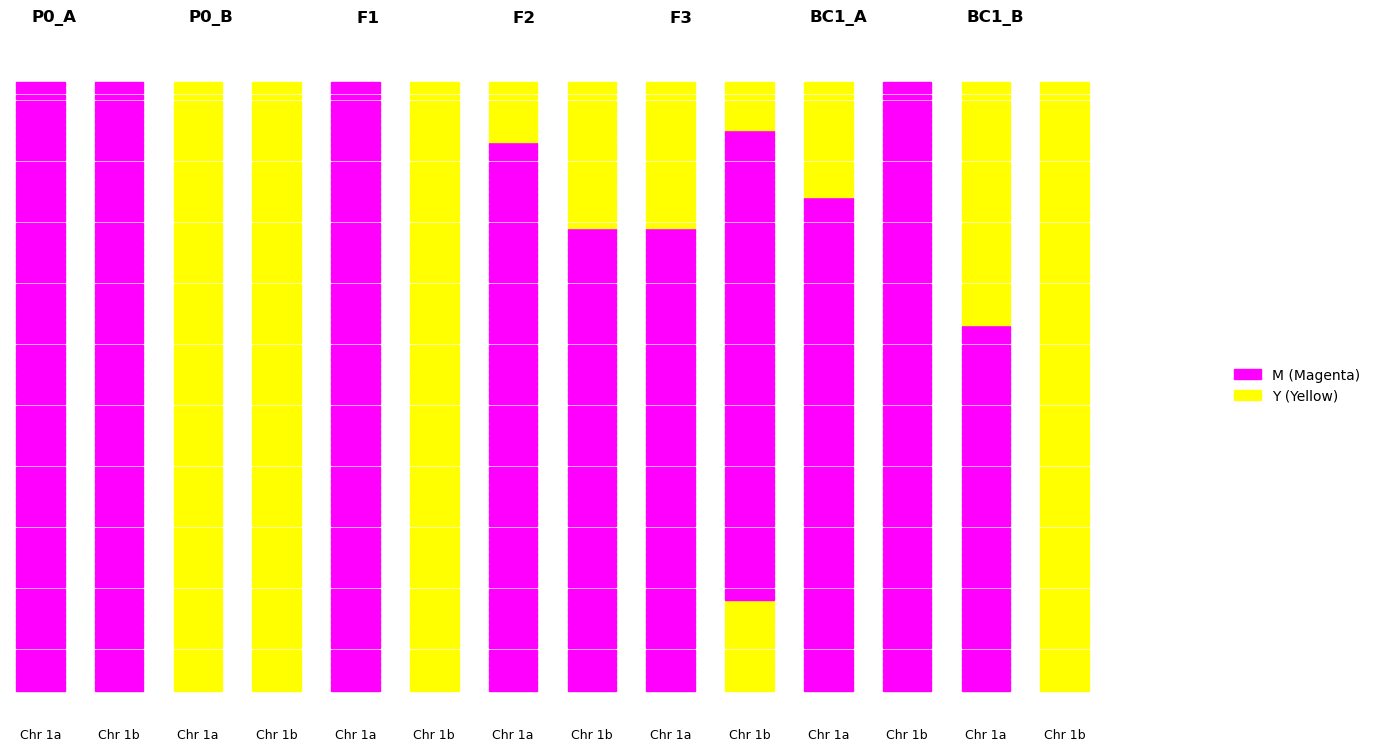

In [66]:
# Visualise Representative Chromosomes Across Generations

print("\n--- Visualising Representative Chromosomes ---")

# 1. Select representative individuals from the generated populations.
# P0_A: The initial Magenta homozygous parent.
representative_p0_a = p0_a_individual
# P0_B: The initial Yellow homozygous parent.
representative_p0_b = p0_b_individual

# F1: The first individual from the F1 generation (all F1s are identical genetically).
representative_f1 = f1_population[0]

# F2: The first individual from the F2 generation.
representative_f2 = f2_population[0]

# F3: The first individual from the F3 generation.
representative_f3 = f3_population[0]

# BC1_A: The first individual from the F1 x P0_A backcross.
representative_bc1_a = bc1_a_population[0]

# BC1_B: The first individual from the F1 x P0_B backcross.
representative_bc1_b = bc1_b_population[0]


# 2. Compile lists of individuals and their corresponding titles for the plotting function.
individuals_to_plot = [
    representative_p0_a,
    representative_p0_b,
    representative_f1,
    representative_f2,
    representative_f3,
    representative_bc1_a,
    representative_bc1_b
]

titles = [
    "P0_A",
    "P0_B",
    "F1",
    "F2",
    "F3",
    "BC1_A",
    "BC1_B"
]

# Call the plotting function.
# We'll plot only the first chromosome pair for each individual for clarity across generations.
# 'max_chromosomes_to_plot=1' ensures only one diploid pair is shown per individual,
# which is crucial for individuals with many chromosome pairs (like F2 onwards).
plot_individual_chromosomes(individuals_to_plot, titles, chromosome_length, max_chromosomes_to_plot=1)

### Triangle Plot


--- Plotting Triangle Plot ---


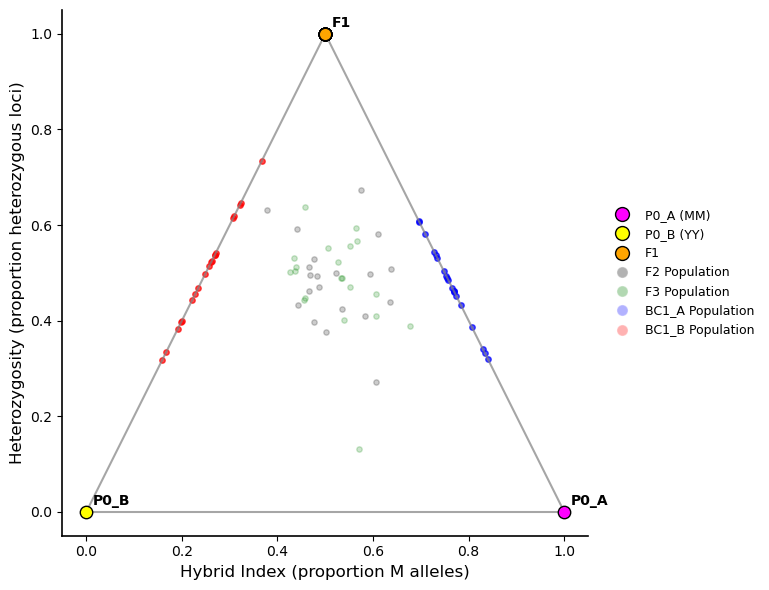

In [67]:
# Triangle Plot
# This cell is responsible for visualising the genetic data on a triangle plot (Hybrid Index vs. Heterozygosity).
# Each point on this plot represents a single individual, showing their overall hybrid status.
# This plot provides a concise summary of the genetic composition of a hybrid population.

print("\n--- Plotting Triangle Plot ---")

# Create a new figure and a single subplot for the plot.
# 'figsize=(8, 6)' sets the width and height of the plot in inches.
fig, ax = plt.subplots(figsize=(8, 6))

# Customise the plot's appearance by removing the top and right spines (borders)
# for a cleaner look, and setting the line width for the bottom and left spines.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Set the labels for the X and Y axes, making them descriptive and readable.
ax.set_xlabel("Hybrid Index (proportion M alleles)", fontsize=12)
ax.set_ylabel("Heterozygosity (proportion heterozygous loci)", fontsize=12)

# Plot the F2 individuals as a scatter plot.
ax.scatter(
    f2_hi_values,    # X-coordinates: Hybrid Index for each F2 individual.
    f2_het_values, # Y-coordinates: Heterozygosity for each F2 individual.
    color='black',         # Colour of the scatter points.
    alpha=0.2,             # Transparency level.
    s=15,                  # Size of the markers.
    label='F2 Population' # Label for this data series, used in the legend.
)

# Plot the F3 individuals as a scatter plot.
ax.scatter(
    f3_hi_values,    # X-coordinates: Hybrid Index for each F3 individual.
    f3_het_values, # Y-coordinates: Heterozygosity for each F3 individual.
    color='green',         # Colour of the scatter points.
    alpha=0.2,             # Transparency level.
    s=15,                  # Size of the markers.
    label='F3 Population' # Label for this data series, used in the legend.
)

# Plot the BC1_A individuals as a scatter plot.
# CORRECTED: Changed bc2_a_hi_values to bc1_a_hi_values and label to BC1_A
ax.scatter(
    bc1_a_hi_values,    # X-coordinates: Hybrid Index for each BC1_A individual.
    bc1_a_het_values, # Y-coordinates: Heterozygosity for each BC1_A individual.
    color='blue',          # Colour of the scatter points.
    alpha=0.7,             # Transparency level.
    s=15,                  # Size of the markers.
    label='BC1_A Population' # Label for this data series, used in the legend.
)

# Plot the BC1_B individuals as a scatter plot.
ax.scatter(
    bc1_b_hi_values,    # X-coordinates: Hybrid Index for each BC1_B individual.
    bc1_b_het_values, # Y-coordinates: Heterozygosity for each BC1_B individual.
    color='red',           # Colour of the scatter points.
    alpha=0.7,             # Transparency level.
    s=15,                  # Size of the markers.
    label='BC1_B Population' # Label for this data series, used in the legend.
)

# Plot the parental (P0) and F1 reference points on the same plot.
ax.scatter(p0_a_hi, p0_a_het, color='magenta', s=80, edgecolor='black', zorder=5, label='P0_A (MM)') # Magenta parent, zorder for visibility
ax.scatter(p0_b_hi, p0_b_het, color='yellow', s=80, edgecolor='black', zorder=5, label='P0_B (YY)') # Yellow parent
ax.scatter(f1_hi_values, f1_het_values, color='orange', s=80, edgecolor='black', zorder=5, label='F1') # F1 generation

# Add annotations (text labels) next to the P0 and F1 points for clear identification on the plot.
ax.annotate('P0_A', (p0_a_hi, p0_a_het), xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
ax.annotate('P0_B', (p0_b_hi, p0_b_het), xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
# For F1, since f1_hi_values and f1_het_values are lists (even if they typically contain one value for F1 average),
# you should use the first element or the mean if you intend to plot the average F1 point.
# Given your average calculation print, using the mean is appropriate here.
ax.annotate('F1', (np.mean(f1_hi_values), np.mean(f1_het_values)), xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')

# Draw the edges of the triangular region.
triangle_edges = [
    [(0.0, 0.0), (0.5, 1.0)], # Edge from YY (0,0) to F1 (0.5,1)
    [(0.5, 1.0), (1.0, 0.0)], # Edge from F1 (0.5,1) to MM (1,0)
    [(0.0, 0.0), (1.0, 0.0)]  # Edge from YY (0,0) to MM (1,0) (the x-axis, representing pure homozygotes)
]
for (x0, y0), (x1, y1) in triangle_edges:
    ax.plot([x0, x1], [y0, y1], linestyle='-', color='gray', linewidth=1.5, alpha=0.7)

# Set the limits for the X and Y axes.
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')

# Create custom legend elements.
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='magenta', markersize=10, markeredgecolor='black', label='P0_A (MM)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, markeredgecolor='black', label='P0_B (YY)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, markeredgecolor='black', label='F1'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', alpha=0.3, markersize=8, label='F2 Population'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', alpha=0.3, markersize=8, label='F3 Population'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', alpha=0.3, markersize=8, label='BC1_A Population'), # Label matches scatter
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', alpha=0.3, markersize=8, label='BC1_B Population')
]

# Add the legend to the plot.
ax.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False, fontsize=9)

# Adjust plot layout.
plt.tight_layout()
plt.subplots_adjust(right=0.8)
plt.show()

### Data Aggregation and DataFrame Creation 

In [68]:
# Data Aggregation and DataFrame Creation

# Dataframe 1: Create the main genetic data DataFrame (locus-level genotypes)
df_genetic_data = pd.DataFrame(genetic_data_records)
print("\n Locus-Level Genetic Data DataFrame")
print(df_genetic_data.head())
print(f"Total records in df_genetic_data: {len(df_genetic_data)}")

# Debugging prints to check global list populations
print(f"\nDEBUG: Length of all_individuals_created: {len(all_individuals_created)}")
print(f"DEBUG: Length of chromatid_recombination_records: {len(chromatid_recombination_records)}")


# DataFrame 2: Individual-Level Summary of Recombination Blocks and Junctions
# This DataFrame will have one row per individual, summarising recombination across all their chromatids.
individual_recombination_summary_records = []
for individual in all_individuals_created:
    # Filter chromatid records for the current individual
    individual_chromatid_records = [
        rec for rec in chromatid_recombination_records
        if rec['individual_id'] == individual.id
    ]

    total_m_blocks = 0
    total_y_blocks = 0
    all_junctions_per_chromatid = []
    all_num_blocks_per_chromatid = []
    all_avg_block_lengths_per_chromatid = []

    for chromatid_rec in individual_chromatid_records:
        # Count M and Y blocks
        total_m_blocks += chromatid_rec['block_alleles'].count(MAGENTA)
        total_y_blocks += chromatid_rec['block_alleles'].count(YELLOW)

        # Collect data for per-chromatid statistics
        all_junctions_per_chromatid.append(chromatid_rec['total_junctions'])
        all_num_blocks_per_chromatid.append(len(chromatid_rec['block_lengths']))
        if chromatid_rec['block_lengths']: # Avoid division by zero if block_lengths is empty
            all_avg_block_lengths_per_chromatid.append(np.mean(chromatid_rec['block_lengths']))
        else:
            all_avg_block_lengths_per_chromatid.append(0) # Or np.nan, depending on desired handling

    # Calculate summary statistics for the individual
    mean_junctions = np.mean(all_junctions_per_chromatid) if all_junctions_per_chromatid else 0
    std_junctions = np.std(all_junctions_per_chromatid) if len(all_junctions_per_chromatid) > 1 else 0

    mean_num_blocks = np.mean(all_num_blocks_per_chromatid) if all_num_blocks_per_chromatid else 0
    std_num_blocks = np.std(all_num_blocks_per_chromatid) if len(all_num_blocks_per_chromatid) > 1 else 0

    mean_avg_block_length = np.mean(all_avg_block_lengths_per_chromatid) if all_avg_block_lengths_per_chromatid else 0
    std_avg_block_length = np.std(all_avg_block_lengths_per_chromatid) if len(all_avg_block_lengths_per_chromatid) > 1 else 0


    individual_recombination_summary_records.append({
        'Individual_ID': individual.id,
        'Generation': individual_chromatid_records[0]['generation'] if individual_chromatid_records else 'N/A', # Get generation from first chromatid record
        'Num_Diploid_Chromosomes': individual.num_chromosomes,
        'Hybrid_Index': individual.calculate_hybrid_index(),
        'Heterozygosity': individual.calculate_heterozygosity(),
        'Total_M_Blocks': total_m_blocks,
        'Total_Y_Blocks': total_y_blocks,
        'Mean_Junctions_Per_Chromatid': mean_junctions,
        'Std_Junctions_Per_Chromatid': std_junctions,
        'Mean_Blocks_Per_Chromatid': mean_num_blocks,
        'Std_Blocks_Per_Chromatid': std_num_blocks,
        'Mean_Avg_Block_Length_Per_Chromatid': mean_avg_block_length,
        'Std_Avg_Block_Length_Per_Chromatid': std_avg_block_length
    })

df_recombination_summary = pd.DataFrame(individual_recombination_summary_records)
print("\n Individual-Level Recombination Summary DataFrame")
print(df_recombination_summary.tail())
print(f"Total records in df_recombination_summary: {len(df_recombination_summary)}")


# DataFrame 3: Detailed Block Data
# This DataFrame will have one row per block
simplified_block_records = []
for record in chromatid_recombination_records:
    for block_idx in range(len(record['block_lengths'])):
        simplified_block_records.append({
            'Individual_ID': record['individual_id'],
            'Generation': record['generation'],
            'Block_Length': record['block_lengths'][block_idx],
            'Ancestry': record['block_alleles'][block_idx]
        })

df_simplified_blocks = pd.DataFrame(simplified_block_records)
print("\n Sample of Simplified Blocks DataFrame")
print(df_simplified_blocks.tail())
print(f"Total records in df_simplified_blocks: {len(df_simplified_blocks)}")

# Optional: Print some summary statistics to verify the structure
#print(f"\nSummary by Generation:")
#print(df_simplified_blocks.groupby('Generation').size())
#print(f"\nSummary of Ancestry types:")
#print(df_simplified_blocks['Ancestry'].value_counts())


 Locus-Level Genetic Data DataFrame
  generation  individual_id  diploid_chr_id  locus_position genotype
0       P0_A              1               1               0      M|M
1       P0_A              1               1               1      M|M
2       P0_A              1               1               2      M|M
3       P0_A              1               1               3      M|M
4       P0_A              1               1               4      M|M
Total records in df_genetic_data: 122200

DEBUG: Length of all_individuals_created: 142
DEBUG: Length of chromatid_recombination_records: 2444

 Individual-Level Recombination Summary DataFrame
     Individual_ID Generation  Num_Diploid_Chromosomes  Hybrid_Index  \
137            138      BC2_B                       10        0.3390   
138            139      BC2_B                       10        0.2330   
139            140      BC2_B                       10        0.1690   
140            141      BC2_B                       10        0.177

### Save Dataframes

In [69]:
# Create output folder if it doesn't exist
output_folder = 'output_data'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Created folder: {output_folder}")
else:
    print(f"Folder already exists: {output_folder}")

# Save each DataFrame to individual CSV files in the output folder
print("\n Saving DataFrames to CSV files")

# Save DataFrame 1: Locus-level genetic data
df_genetic_data.to_csv(f'{output_folder}/genetic_data_locus_level.csv', index=False)
print("Saved: genetic_data_locus_level.csv")

# Save DataFrame 2: Individual-level recombination summary
df_recombination_summary.to_csv(f'{output_folder}/individual_recombination_summary.csv', index=False)
print("Saved: individual_recombination_summary.csv")

# Save DataFrame 3: Simplified block data
df_simplified_blocks.to_csv(f'{output_folder}/simplified_block_data.csv', index=False)
print("Saved: simplified_block_data.csv")

print(f"\nAll CSV files have been saved to the '{output_folder}' folder")

Folder already exists: output_data

 Saving DataFrames to CSV files
Saved: genetic_data_locus_level.csv
Saved: individual_recombination_summary.csv
Saved: simplified_block_data.csv

All CSV files have been saved to the 'output_data' folder
